<a href="https://colab.research.google.com/github/OELSHARK/Loan_Default_Classification/blob/main/Loan_Default_Prediction2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter

# load data

In [ ]:
import kagglehub

path = kagglehub.dataset_download("nikhil1e9/loan-default")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/loan-default


In [ ]:
import os, pandas as pd

print(path)
os.listdir(path)



/kaggle/input/loan-default


['Loan_default.csv']

# EDA

In [ ]:
df = pd.read_csv(os.path.join(path, 'Loan_default.csv'))
display(df.head())

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [ ]:
def info_data (df):
    print("SHAPE OF DATA ".center(70, '-'))
    print('Rows:{}'.format(df.shape[0]))
    print('Columns: {}'.format(df.shape[1]))
    print(" Types ".center(70, '-'))
    print(df.dtypes)
    print("missing values".center(70, '-'))
    print(df.isnull().sum())
    print("Some statistical measures".center(70, '-'))
    print(df.describe())


info_data(df)

----------------------------SHAPE OF DATA ----------------------------
Rows:255347
Columns: 18
------------------------------- Types --------------------------------
LoanID             object
Age                 int64
Income              int64
LoanAmount          int64
CreditScore         int64
MonthsEmployed      int64
NumCreditLines      int64
InterestRate      float64
LoanTerm            int64
DTIRatio          float64
Education          object
EmploymentType     object
MaritalStatus      object
HasMortgage        object
HasDependents      object
LoanPurpose        object
HasCoSigner        object
Default             int64
dtype: object
----------------------------missing values----------------------------
LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
H

In [ ]:
import os, pandas as pd
pd.set_option("display.max_columns", 50)

# 1) Find and load the CSV
print("Cache path:", path)
files = os.listdir(path)
print("Files found:", files)

csvs = [f for f in files if f.lower().endswith(".csv")]
assert len(csvs) >= 1, "No CSV files found. Paste the file list here."
csv_path = os.path.join(path, csvs[0])  # if multiple CSVs, we’ll pick explicitly after you show me the list
print("Using CSV:", csv_path)

df = pd.read_csv(csv_path)
print(df.shape)
display(df.head())
df.info()

# 2) Quick label and ID checks
print("\nLabel distribution:")
print(df["Default"].value_counts(dropna=False))
print("Label ratio (positive %):", df["Default"].mean()*100)

print("\nDuplicate rows:", df.duplicated().sum())
print("Duplicate LoanID:", df.duplicated(subset=["LoanID"]).sum())
print("Unique LoanID:", df["LoanID"].nunique())

# 3) Basic numeric sanity (ranges) + any constant columns
desc = df.describe(include="all").T
display(desc.loc[["Age","Income","LoanAmount","CreditScore","MonthsEmployed","NumCreditLines",
                  "InterestRate","LoanTerm","DTIRatio","Default"]])

const_cols = [c for c in df.columns if df[c].nunique(dropna=False) == 1]
print("Constant columns:", const_cols)


Cache path: /kaggle/input/loan-default
Files found: ['Loan_default.csv']
Using CSV: /kaggle/input/loan-default/Loan_default.csv
(255347, 18)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,255347.0,NaN,NaN,NaN,43.498306,14.990258,18.0,31.0,43.0,56.0,69.0
Income,255347.0,NaN,NaN,NaN,82499.304597,38963.013729,15000.0,48825.5,82466.0,116219.0,149999.0
LoanAmount,255347.0,NaN,NaN,NaN,127578.865512,70840.706142,5000.0,66156.0,127556.0,188985.0,249999.0
CreditScore,255347.0,NaN,NaN,NaN,574.264346,158.903867,300.0,437.0,574.0,712.0,849.0
MonthsEmployed,255347.0,NaN,NaN,NaN,59.541976,34.643376,0.0,30.0,60.0,90.0,119.0
NumCreditLines,255347.0,NaN,NaN,NaN,2.501036,1.117018,1.0,2.0,2.0,3.0,4.0
InterestRate,255347.0,NaN,NaN,NaN,13.492773,6.636443,2.0,7.77,13.46,19.25,25.0
LoanTerm,255347.0,NaN,NaN,NaN,36.025894,16.96933,12.0,24.0,36.0,48.0,60.0
DTIRatio,255347.0,NaN,NaN,NaN,0.500212,0.230917,0.1,0.3,0.5,0.7,0.9
Default,255347.0,NaN,NaN,NaN,0.116128,0.320379,0.0,0.0,0.0,0.0,1.0


Constant columns: []


In [ ]:
df = df.drop(columns="LoanID")

In [ ]:
df.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


In [ ]:
df.duplicated().any()

np.False_

In [ ]:
df.shape

(255347, 17)

In [ ]:
import matplotlib.pyplot as plt

def column_distribution(df, column, normalize=False):
    """
    Show the distribution of a specific column as counts and a bar plot.

    Parameters:
    df : pandas DataFrame
    column : str - the column name
    normalize : bool - if True, shows percentages instead of raw counts
    """
    counts = df[column].value_counts(normalize=normalize)
    print(f"Distribution for '{column}':\n")
    print(counts)

    plt.figure(figsize=(8,4))
    counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Percentage" if normalize else "Count")
    plt.xticks(rotation=45)
    plt.show()



Distribution for 'Education':

Education
Bachelor's     64366
High School    63903
Master's       63541
PhD            63537
Name: count, dtype: int64


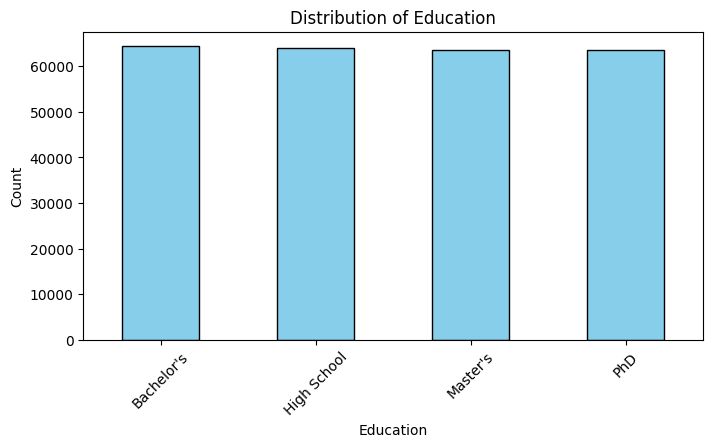

In [ ]:
column_distribution(df, "Education")         # Counts


Distribution for 'Default':

Default
0    0.883872
1    0.116128
Name: proportion, dtype: float64


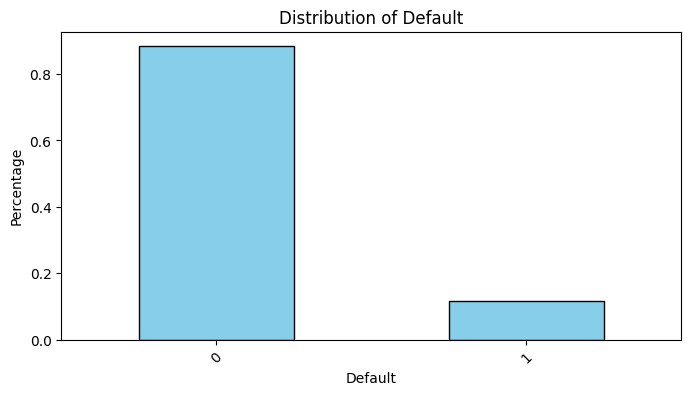

In [ ]:
column_distribution(df, "Default", True)     # Percentages


In [ ]:
import pandas as pd

education_mapping = {
    "High School": 0,
    "Bachelor's": 1,
    "Master's": 2,
    "PhD": 3
}

df["Education"] = df["Education"].map(education_mapping)

print(df["Education"].head(10))


0    1
1    2
2    2
3    0
4    1
5    0
6    1
7    3
8    1
9    0
Name: Education, dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Age             255347 non-null  int64  
 1   Income          255347 non-null  int64  
 2   LoanAmount      255347 non-null  int64  
 3   CreditScore     255347 non-null  int64  
 4   MonthsEmployed  255347 non-null  int64  
 5   NumCreditLines  255347 non-null  int64  
 6   InterestRate    255347 non-null  float64
 7   LoanTerm        255347 non-null  int64  
 8   DTIRatio        255347 non-null  float64
 9   Education       255347 non-null  int64  
 10  EmploymentType  255347 non-null  object 
 11  MaritalStatus   255347 non-null  object 
 12  HasMortgage     255347 non-null  object 
 13  HasDependents   255347 non-null  object 
 14  LoanPurpose     255347 non-null  object 
 15  HasCoSigner     255347 non-null  object 
 16  Default         255347 non-null  int64  
dtypes: float64

In [ ]:
df["EmploymentType"]

,EmploymentType
0,Full-time
1,Full-time
2,Unemployed
3,Full-time
4,Unemployed
...,...
255342,Full-time
255343,Part-time
255344,Self-employed
255345,Part-time


Distribution for 'EmploymentType':

EmploymentType
Part-time        64161
Unemployed       63824
Self-employed    63706
Full-time        63656
Name: count, dtype: int64


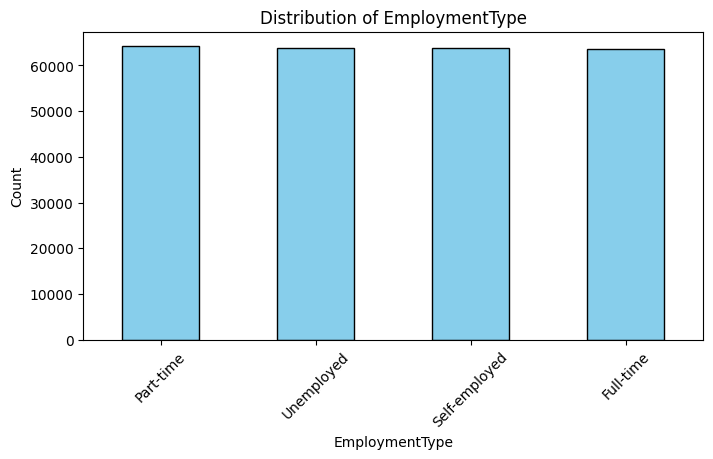

In [ ]:
column_distribution(df, "EmploymentType")

In [ ]:
df["EmploymentType"].unique()

array(['Full-time', 'Unemployed', 'Self-employed', 'Part-time'],
      dtype=object)

In [ ]:
EmploymentType_mapping ={
    'Full-time':0,
    'Part-time':1,
    'Self-employed':2,
    'Unemployed':3
}

df["EmploymentType"] = df["EmploymentType"].map(EmploymentType_mapping)
print(df["EmploymentType"].head(10))

0    0
1    0
2    3
3    0
4    3
5    3
6    3
7    0
8    2
9    2
Name: EmploymentType, dtype: int64


In [ ]:
def encode_column(df, column, order=None):
    """
    Encode a categorical column into numeric values.

    Parameters:
    df : pandas DataFrame
    column : str - column name
    order : list - custom order of categories (optional)

    If no order is provided, categories will be encoded in sorted order.
    """
    if order:
        mapping = {cat: idx for idx, cat in enumerate(order)}
    else:
        unique_values = sorted(df[column].unique())
        mapping = {cat: idx for idx, cat in enumerate(unique_values)}

    df[column] = df[column].map(mapping)
    return mapping

# # Example 1: Custom order (for Education)
# edu_mapping = encode_column(df, "Education", ["High School", "Bachelor's", "Master's", "PhD"])
# print("Education mapping:", edu_mapping)

# # Example 2: Auto order (alphabetical for EmploymentType)
# emp_mapping = encode_column(df, "EmploymentType")
# print("EmploymentType mapping:", emp_mapping)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Age             255347 non-null  int64  
 1   Income          255347 non-null  int64  
 2   LoanAmount      255347 non-null  int64  
 3   CreditScore     255347 non-null  int64  
 4   MonthsEmployed  255347 non-null  int64  
 5   NumCreditLines  255347 non-null  int64  
 6   InterestRate    255347 non-null  float64
 7   LoanTerm        255347 non-null  int64  
 8   DTIRatio        255347 non-null  float64
 9   Education       255347 non-null  int64  
 10  EmploymentType  255347 non-null  int64  
 11  MaritalStatus   255347 non-null  object 
 12  HasMortgage     255347 non-null  object 
 13  HasDependents   255347 non-null  object 
 14  LoanPurpose     255347 non-null  object 
 15  HasCoSigner     255347 non-null  object 
 16  Default         255347 non-null  int64  
dtypes: float64

In [ ]:
df["MaritalStatus"].unique()

array(['Divorced', 'Married', 'Single'], dtype=object)

In [ ]:
MaritalStatus_mapping =encode_column(df, "MaritalStatus")
print(MaritalStatus_mapping)

{'Divorced': 0, 'Married': 1, 'Single': 2}


Distribution for 'MaritalStatus':

MaritalStatus
1    85302
0    85033
2    85012
Name: count, dtype: int64


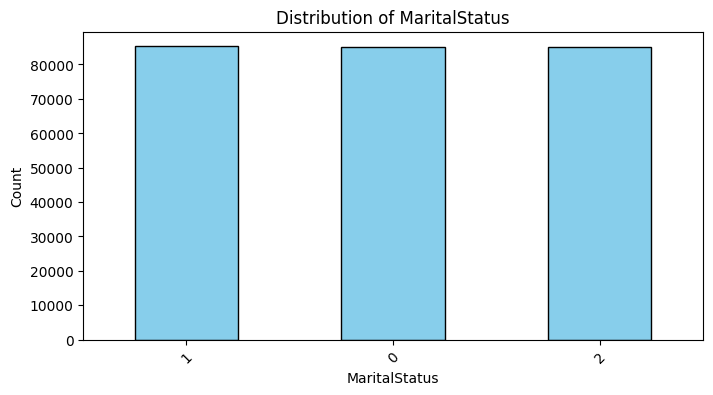

In [ ]:
column_distribution(df, "MaritalStatus")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Age             255347 non-null  int64  
 1   Income          255347 non-null  int64  
 2   LoanAmount      255347 non-null  int64  
 3   CreditScore     255347 non-null  int64  
 4   MonthsEmployed  255347 non-null  int64  
 5   NumCreditLines  255347 non-null  int64  
 6   InterestRate    255347 non-null  float64
 7   LoanTerm        255347 non-null  int64  
 8   DTIRatio        255347 non-null  float64
 9   Education       255347 non-null  int64  
 10  EmploymentType  255347 non-null  int64  
 11  MaritalStatus   255347 non-null  int64  
 12  HasMortgage     255347 non-null  object 
 13  HasDependents   255347 non-null  object 
 14  LoanPurpose     255347 non-null  object 
 15  HasCoSigner     255347 non-null  object 
 16  Default         255347 non-null  int64  
dtypes: float64

In [ ]:
df["HasMortgage"].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
df["HasMortgage"] = df["HasMortgage"].map({"No": 0, "Yes": 1})


In [ ]:
df['HasMortgage'].unique()

array([1, 0])

In [ ]:
df['HasDependents'].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
df['HasDependents'] = df['HasDependents'].map({'No': 0, 'Yes': 1})

In [ ]:
df['LoanPurpose'].unique()

array(['Other', 'Auto', 'Business', 'Home', 'Education'], dtype=object)

In [ ]:
LoanPurpose_mapping = encode_column(df, "LoanPurpose")
print(LoanPurpose_mapping)

{'Auto': 0, 'Business': 1, 'Education': 2, 'Home': 3, 'Other': 4}


In [ ]:
df['HasCoSigner'].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
df['HasCoSigner'] = df['HasCoSigner'].map({'No' : 0, 'Yes' : 1})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Age             255347 non-null  int64  
 1   Income          255347 non-null  int64  
 2   LoanAmount      255347 non-null  int64  
 3   CreditScore     255347 non-null  int64  
 4   MonthsEmployed  255347 non-null  int64  
 5   NumCreditLines  255347 non-null  int64  
 6   InterestRate    255347 non-null  float64
 7   LoanTerm        255347 non-null  int64  
 8   DTIRatio        255347 non-null  float64
 9   Education       255347 non-null  int64  
 10  EmploymentType  255347 non-null  int64  
 11  MaritalStatus   255347 non-null  int64  
 12  HasMortgage     255347 non-null  int64  
 13  HasDependents   255347 non-null  int64  
 14  LoanPurpose     255347 non-null  int64  
 15  HasCoSigner     255347 non-null  int64  
 16  Default         255347 non-null  int64  
dtypes: float64

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def boxplot_column(df, column):
    """
    Draw a boxplot for a specific numeric column to visualize outliers.

    Parameters:
    df : pandas DataFrame
    column : str - the column name
    """
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[column], color='skyblue')
    plt.title(f"Boxplot of {column}")
    plt.xlabel(column)
    plt.show()

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    print(f"Lower bound: {lower_bound}")
    print(f"Upper bound: {upper_bound}")
    print(f"Number of outliers in '{column}': {outliers.shape[0]}")
    return outliers




--- Age ---


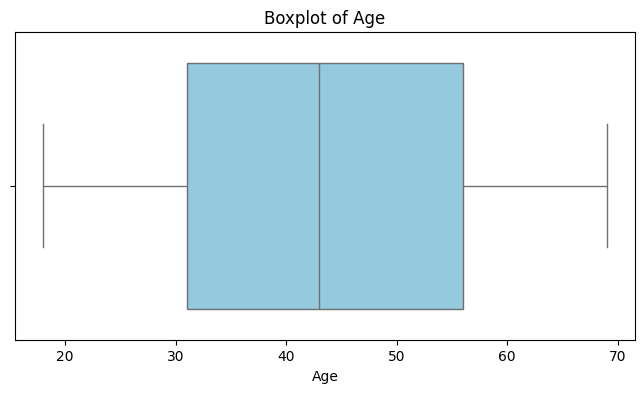

Lower bound: -6.5
Upper bound: 93.5
Number of outliers in 'Age': 0
--- Income ---


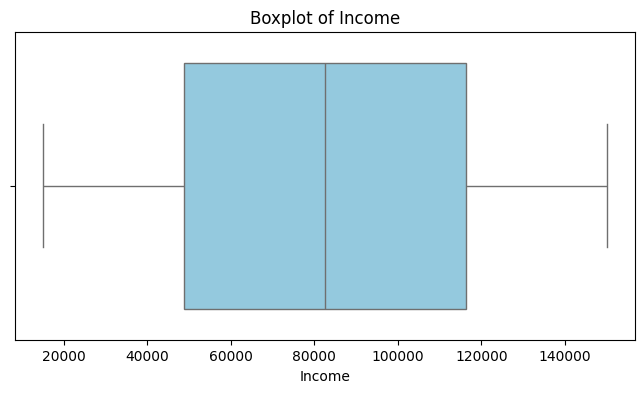

Lower bound: -52264.75
Upper bound: 217309.25
Number of outliers in 'Income': 0
--- LoanAmount ---


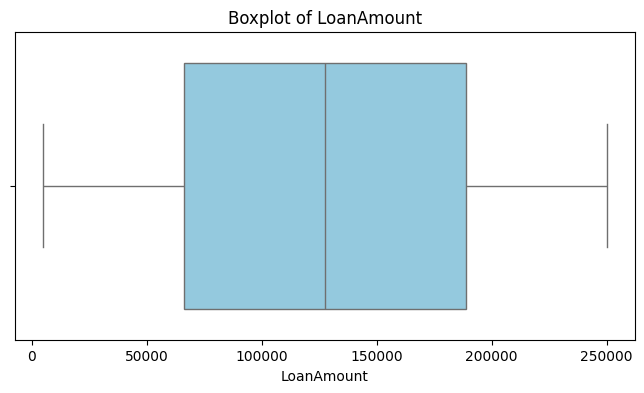

Lower bound: -118087.5
Upper bound: 373228.5
Number of outliers in 'LoanAmount': 0
--- CreditScore ---


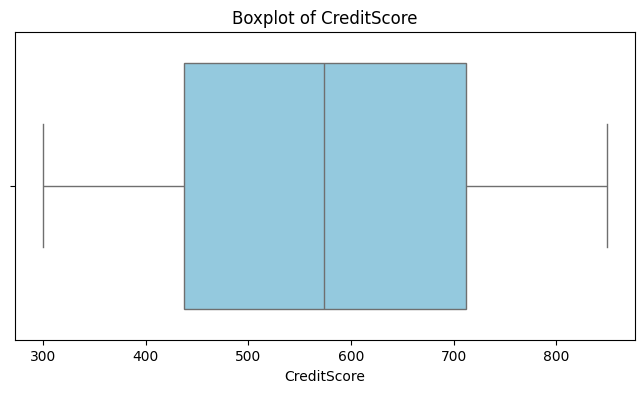

Lower bound: 24.5
Upper bound: 1124.5
Number of outliers in 'CreditScore': 0
--- MonthsEmployed ---


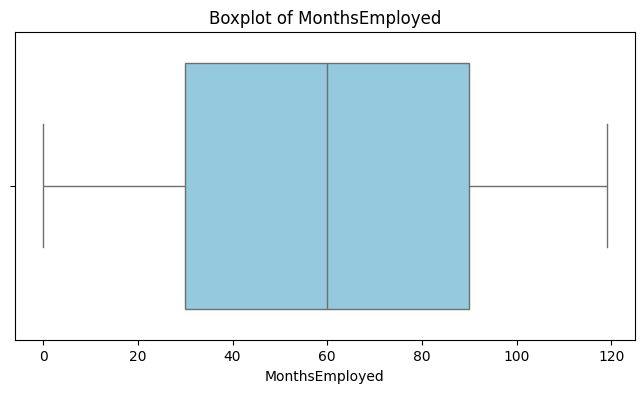

Lower bound: -60.0
Upper bound: 180.0
Number of outliers in 'MonthsEmployed': 0
--- NumCreditLines ---


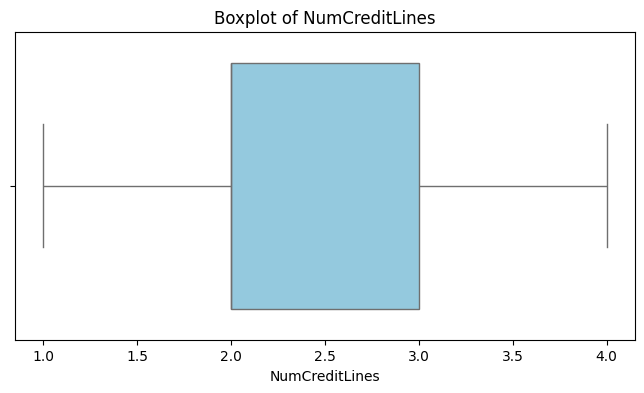

Lower bound: 0.5
Upper bound: 4.5
Number of outliers in 'NumCreditLines': 0
--- InterestRate ---


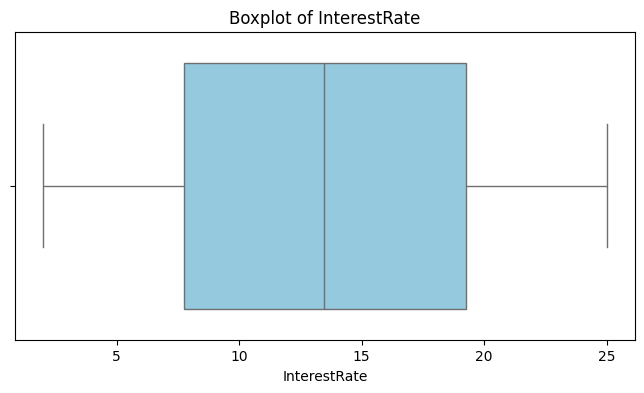

Lower bound: -9.45
Upper bound: 36.47
Number of outliers in 'InterestRate': 0
--- LoanTerm ---


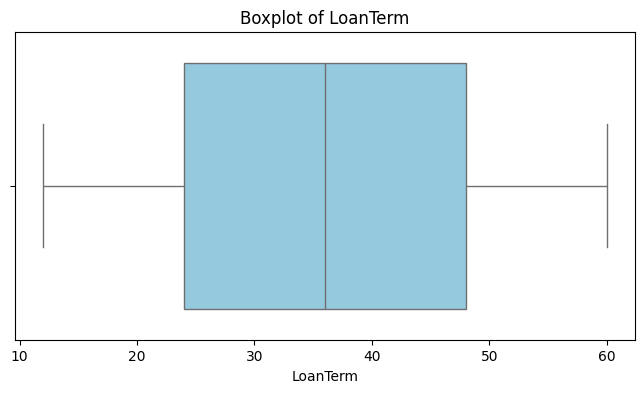

Lower bound: -12.0
Upper bound: 84.0
Number of outliers in 'LoanTerm': 0
--- DTIRatio ---


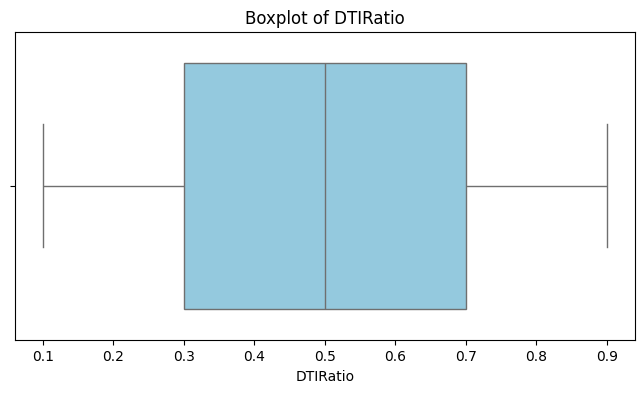

Lower bound: -0.3
Upper bound: 1.2999999999999998
Number of outliers in 'DTIRatio': 0
--- Education ---


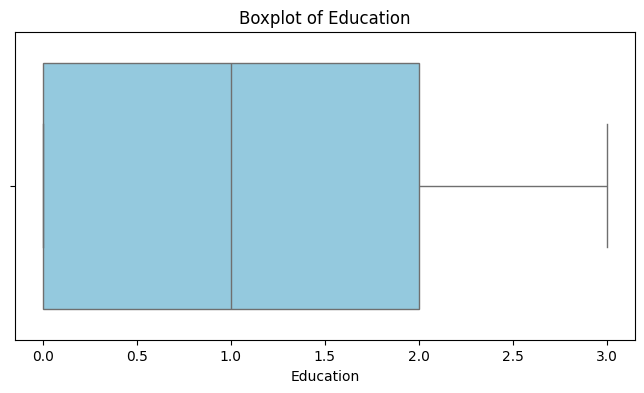

Lower bound: -3.0
Upper bound: 5.0
Number of outliers in 'Education': 0
--- EmploymentType ---


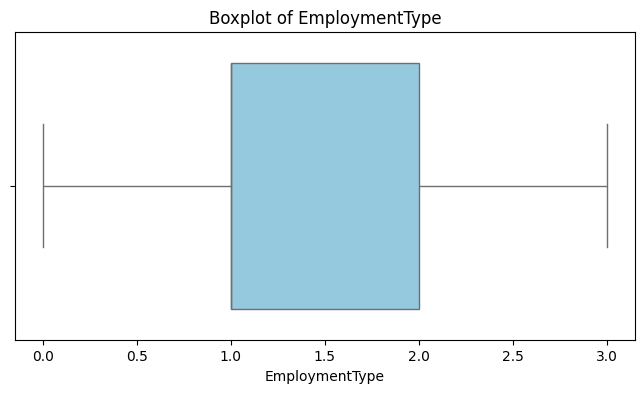

Lower bound: -0.5
Upper bound: 3.5
Number of outliers in 'EmploymentType': 0
--- MaritalStatus ---


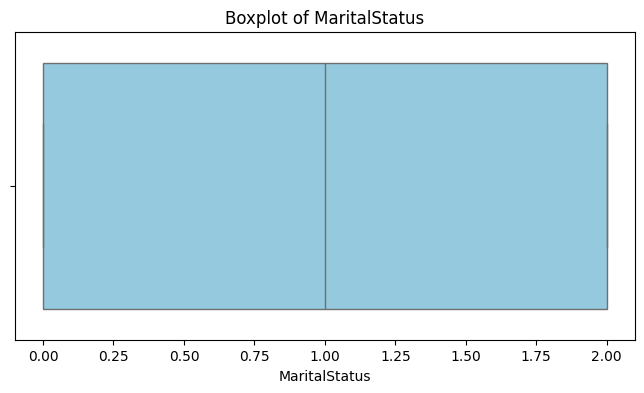

Lower bound: -3.0
Upper bound: 5.0
Number of outliers in 'MaritalStatus': 0
--- HasMortgage ---


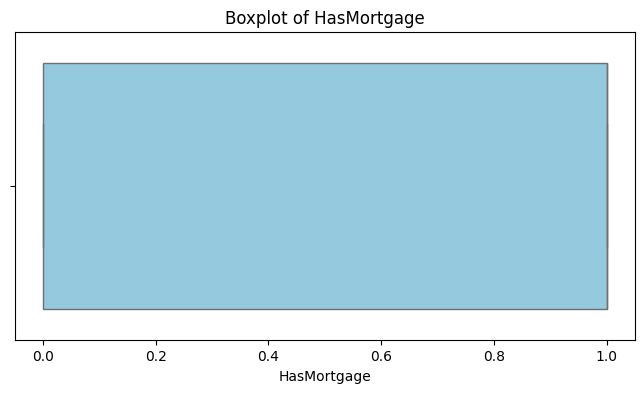

Lower bound: -1.5
Upper bound: 2.5
Number of outliers in 'HasMortgage': 0
--- HasDependents ---


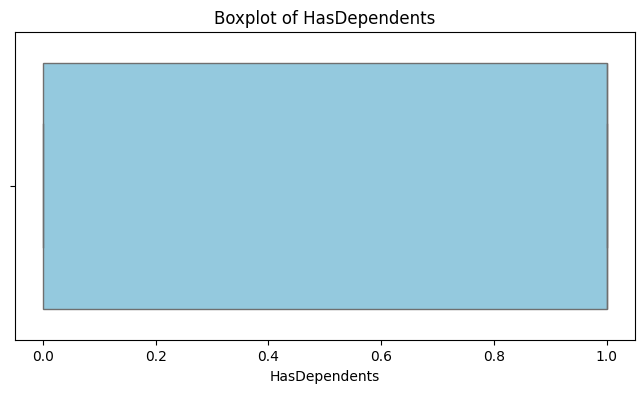

Lower bound: -1.5
Upper bound: 2.5
Number of outliers in 'HasDependents': 0
--- LoanPurpose ---


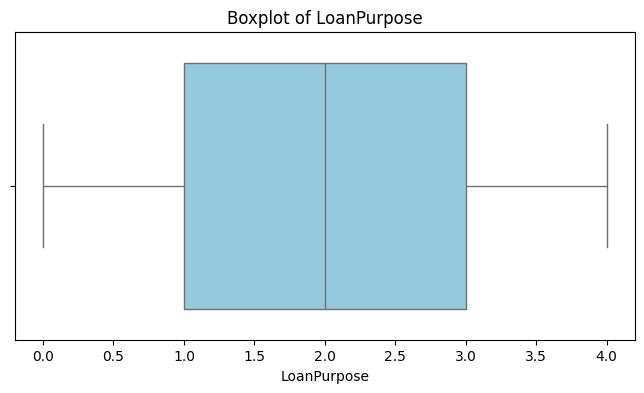

Lower bound: -2.0
Upper bound: 6.0
Number of outliers in 'LoanPurpose': 0
--- HasCoSigner ---


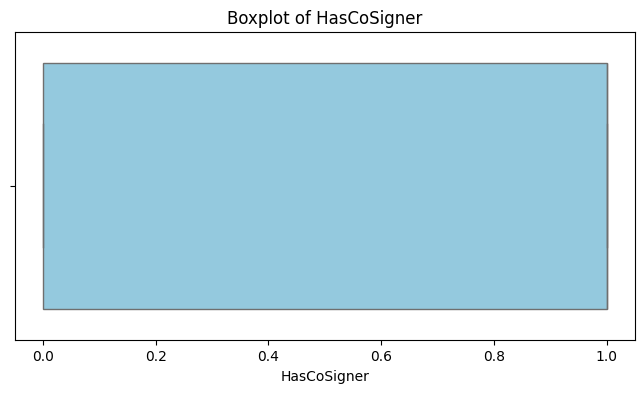

Lower bound: -1.5
Upper bound: 2.5
Number of outliers in 'HasCoSigner': 0
--- Default ---


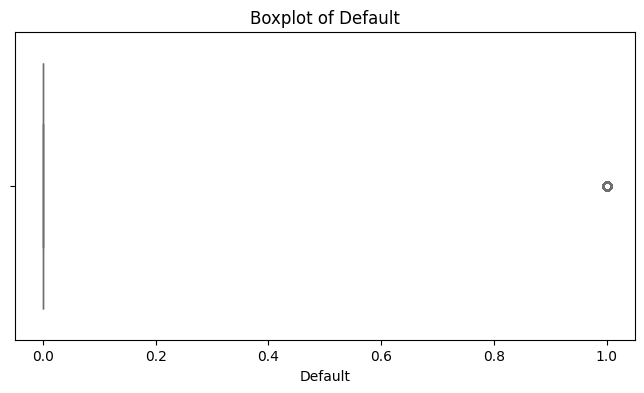

Lower bound: 0.0
Upper bound: 0.0
Number of outliers in 'Default': 29653


In [ ]:
# numeric columns only
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

#  draw boxplots
for col in num_cols:
    print(f"--- {col} ---")
    boxplot_column(df, col)


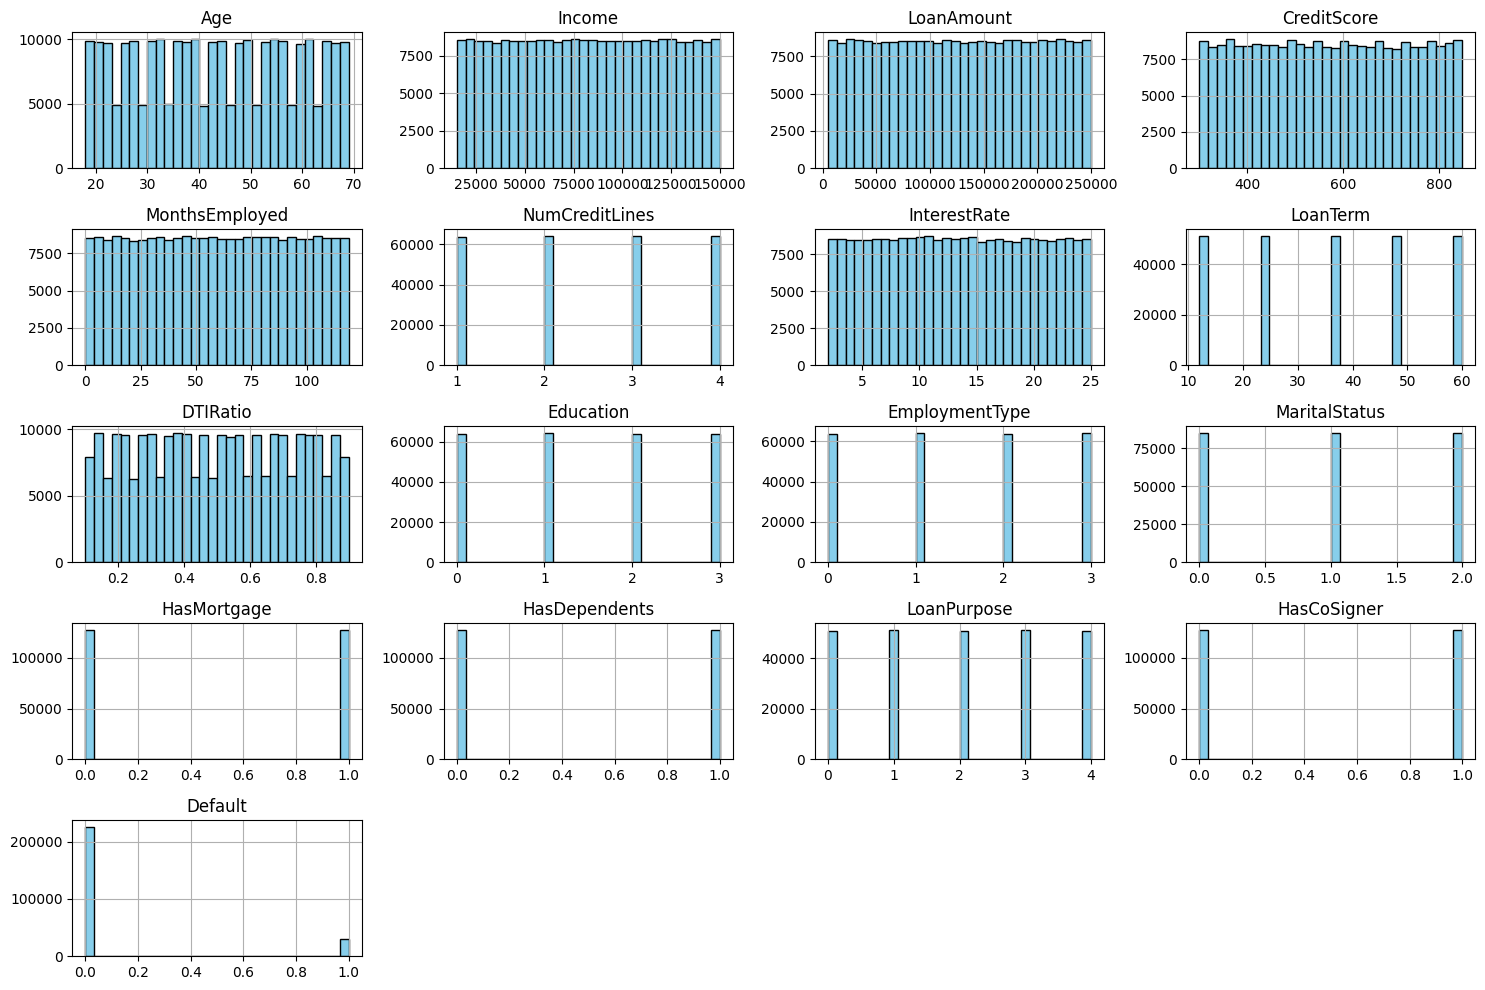

In [ ]:
import matplotlib.pyplot as plt

def hist_all_numeric(df):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    df[num_cols].hist(figsize=(15, 10), bins=30, color='skyblue', edgecolor='black')
    plt.tight_layout()
    plt.show()

hist_all_numeric(df)


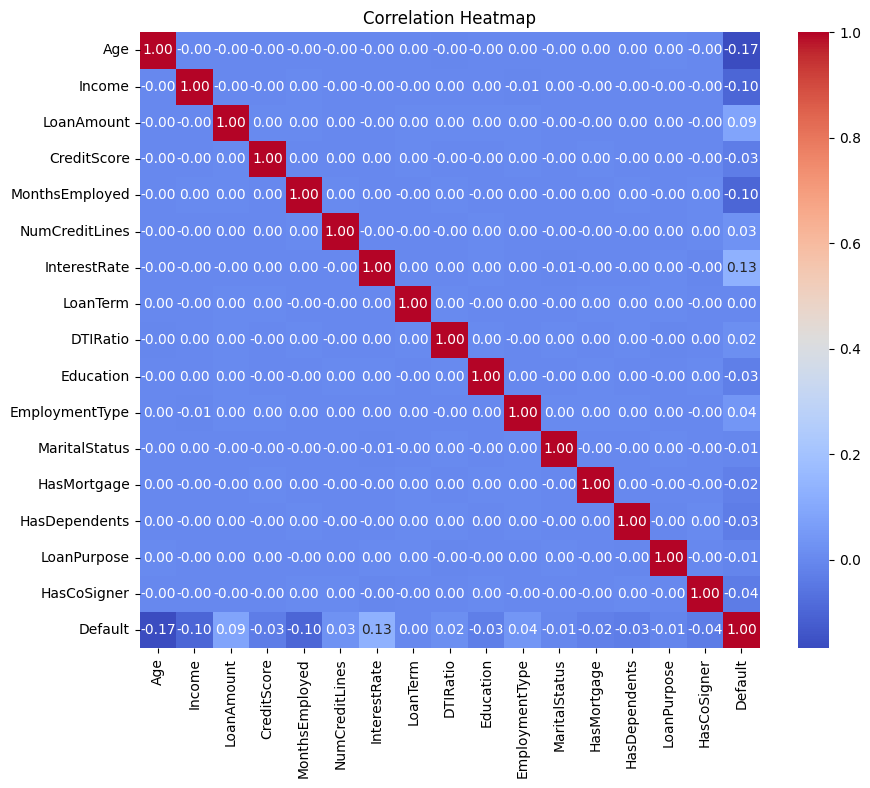

In [ ]:
def correlation_heatmap(df):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()

correlation_heatmap(df)


/tmp/ipython-input-1745145926.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[target], y=df[col], palette='coolwarm')


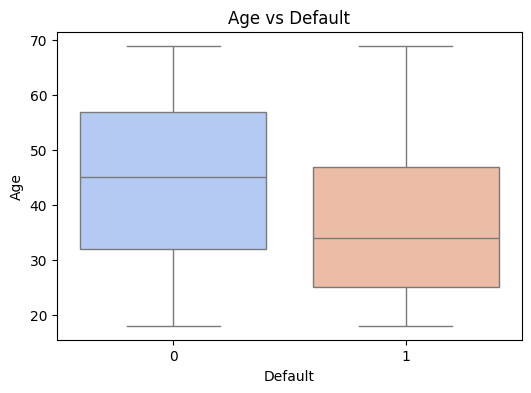

/tmp/ipython-input-1745145926.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[target], y=df[col], palette='coolwarm')


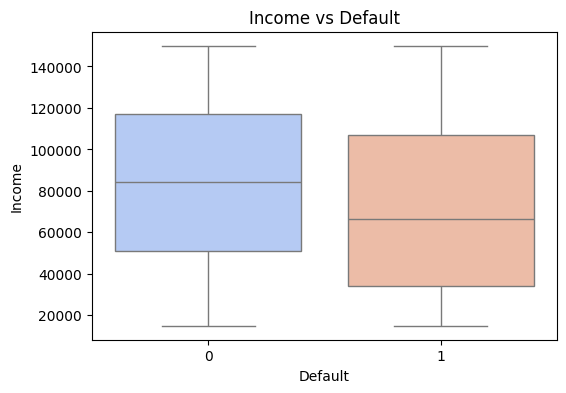

/tmp/ipython-input-1745145926.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[target], y=df[col], palette='coolwarm')


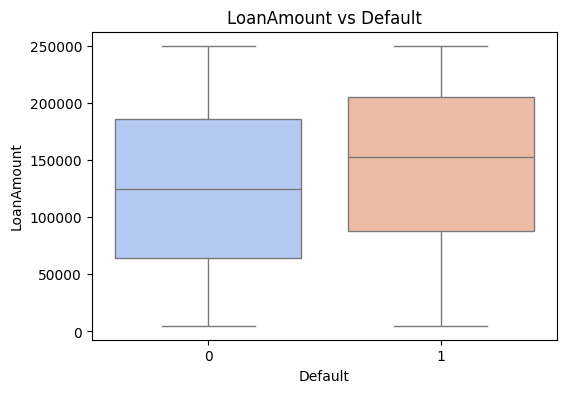

/tmp/ipython-input-1745145926.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[target], y=df[col], palette='coolwarm')


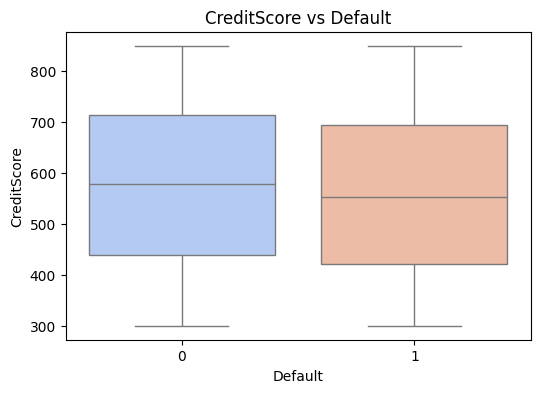

/tmp/ipython-input-1745145926.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[target], y=df[col], palette='coolwarm')


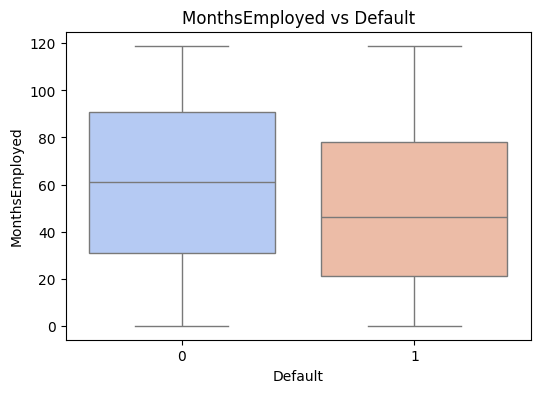

/tmp/ipython-input-1745145926.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[target], y=df[col], palette='coolwarm')


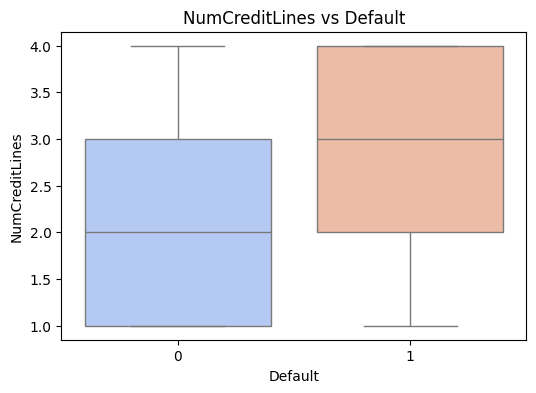

/tmp/ipython-input-1745145926.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[target], y=df[col], palette='coolwarm')


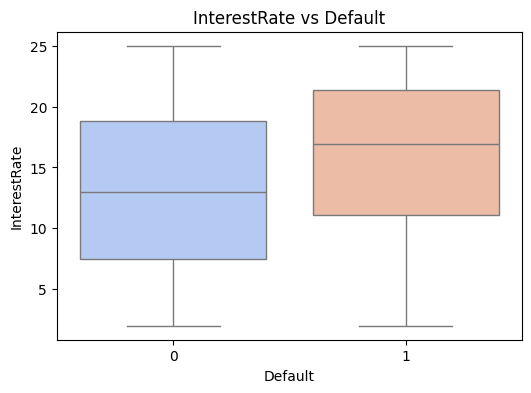

/tmp/ipython-input-1745145926.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[target], y=df[col], palette='coolwarm')


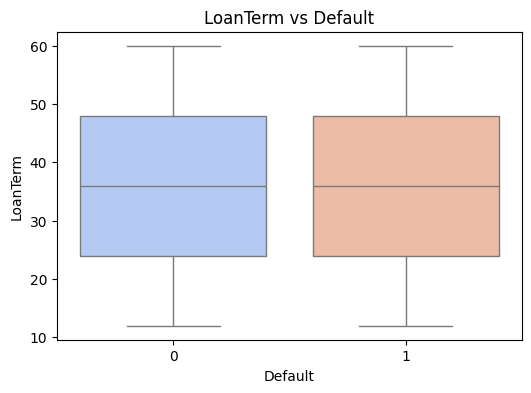

/tmp/ipython-input-1745145926.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[target], y=df[col], palette='coolwarm')


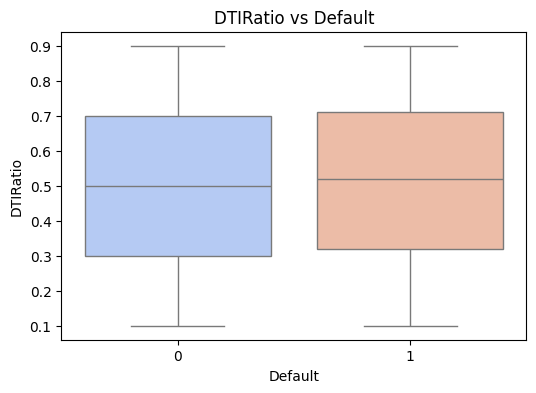

/tmp/ipython-input-1745145926.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[target], y=df[col], palette='coolwarm')


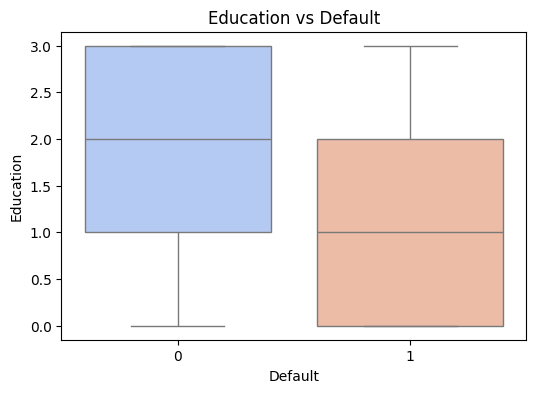

/tmp/ipython-input-1745145926.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[target], y=df[col], palette='coolwarm')


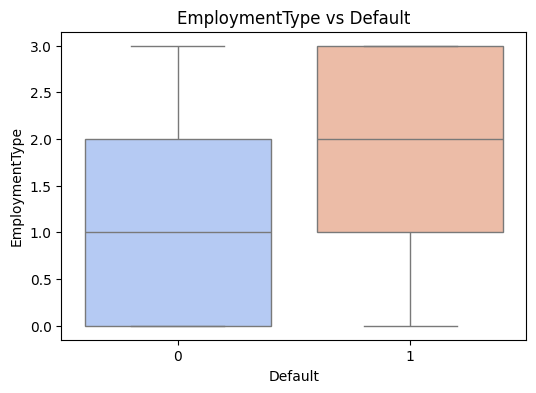

/tmp/ipython-input-1745145926.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[target], y=df[col], palette='coolwarm')


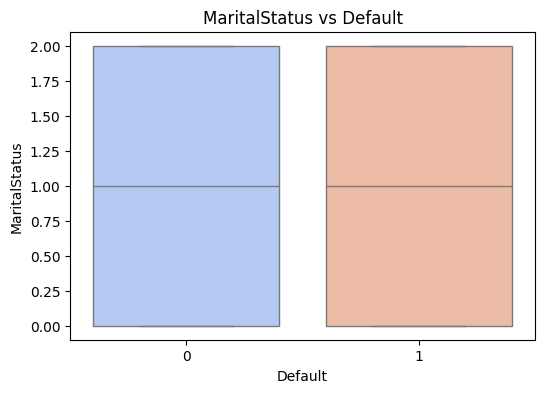

/tmp/ipython-input-1745145926.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[target], y=df[col], palette='coolwarm')


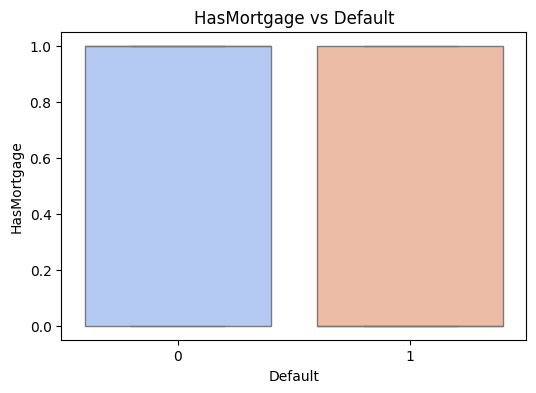

/tmp/ipython-input-1745145926.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[target], y=df[col], palette='coolwarm')


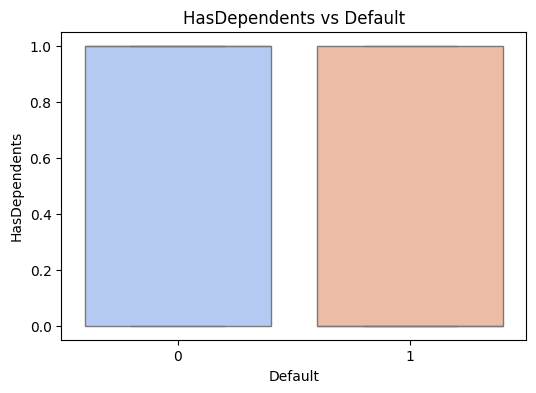

/tmp/ipython-input-1745145926.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[target], y=df[col], palette='coolwarm')


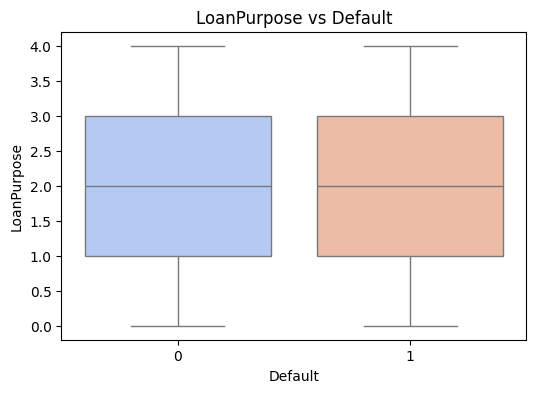

/tmp/ipython-input-1745145926.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[target], y=df[col], palette='coolwarm')


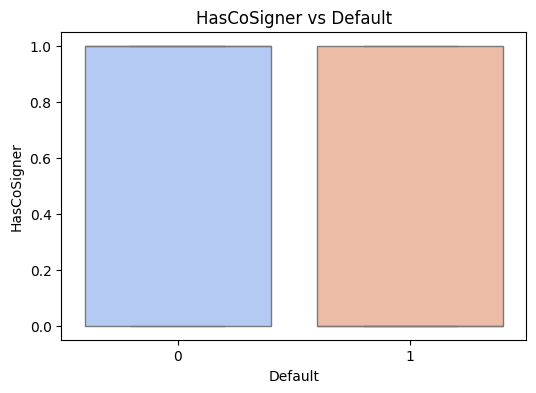

In [ ]:
def target_distribution(df, target):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(target)
    for col in num_cols:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x=df[target], y=df[col], palette='coolwarm')
        plt.title(f"{col} vs {target}")
        plt.show()

target_distribution(df, "Default")


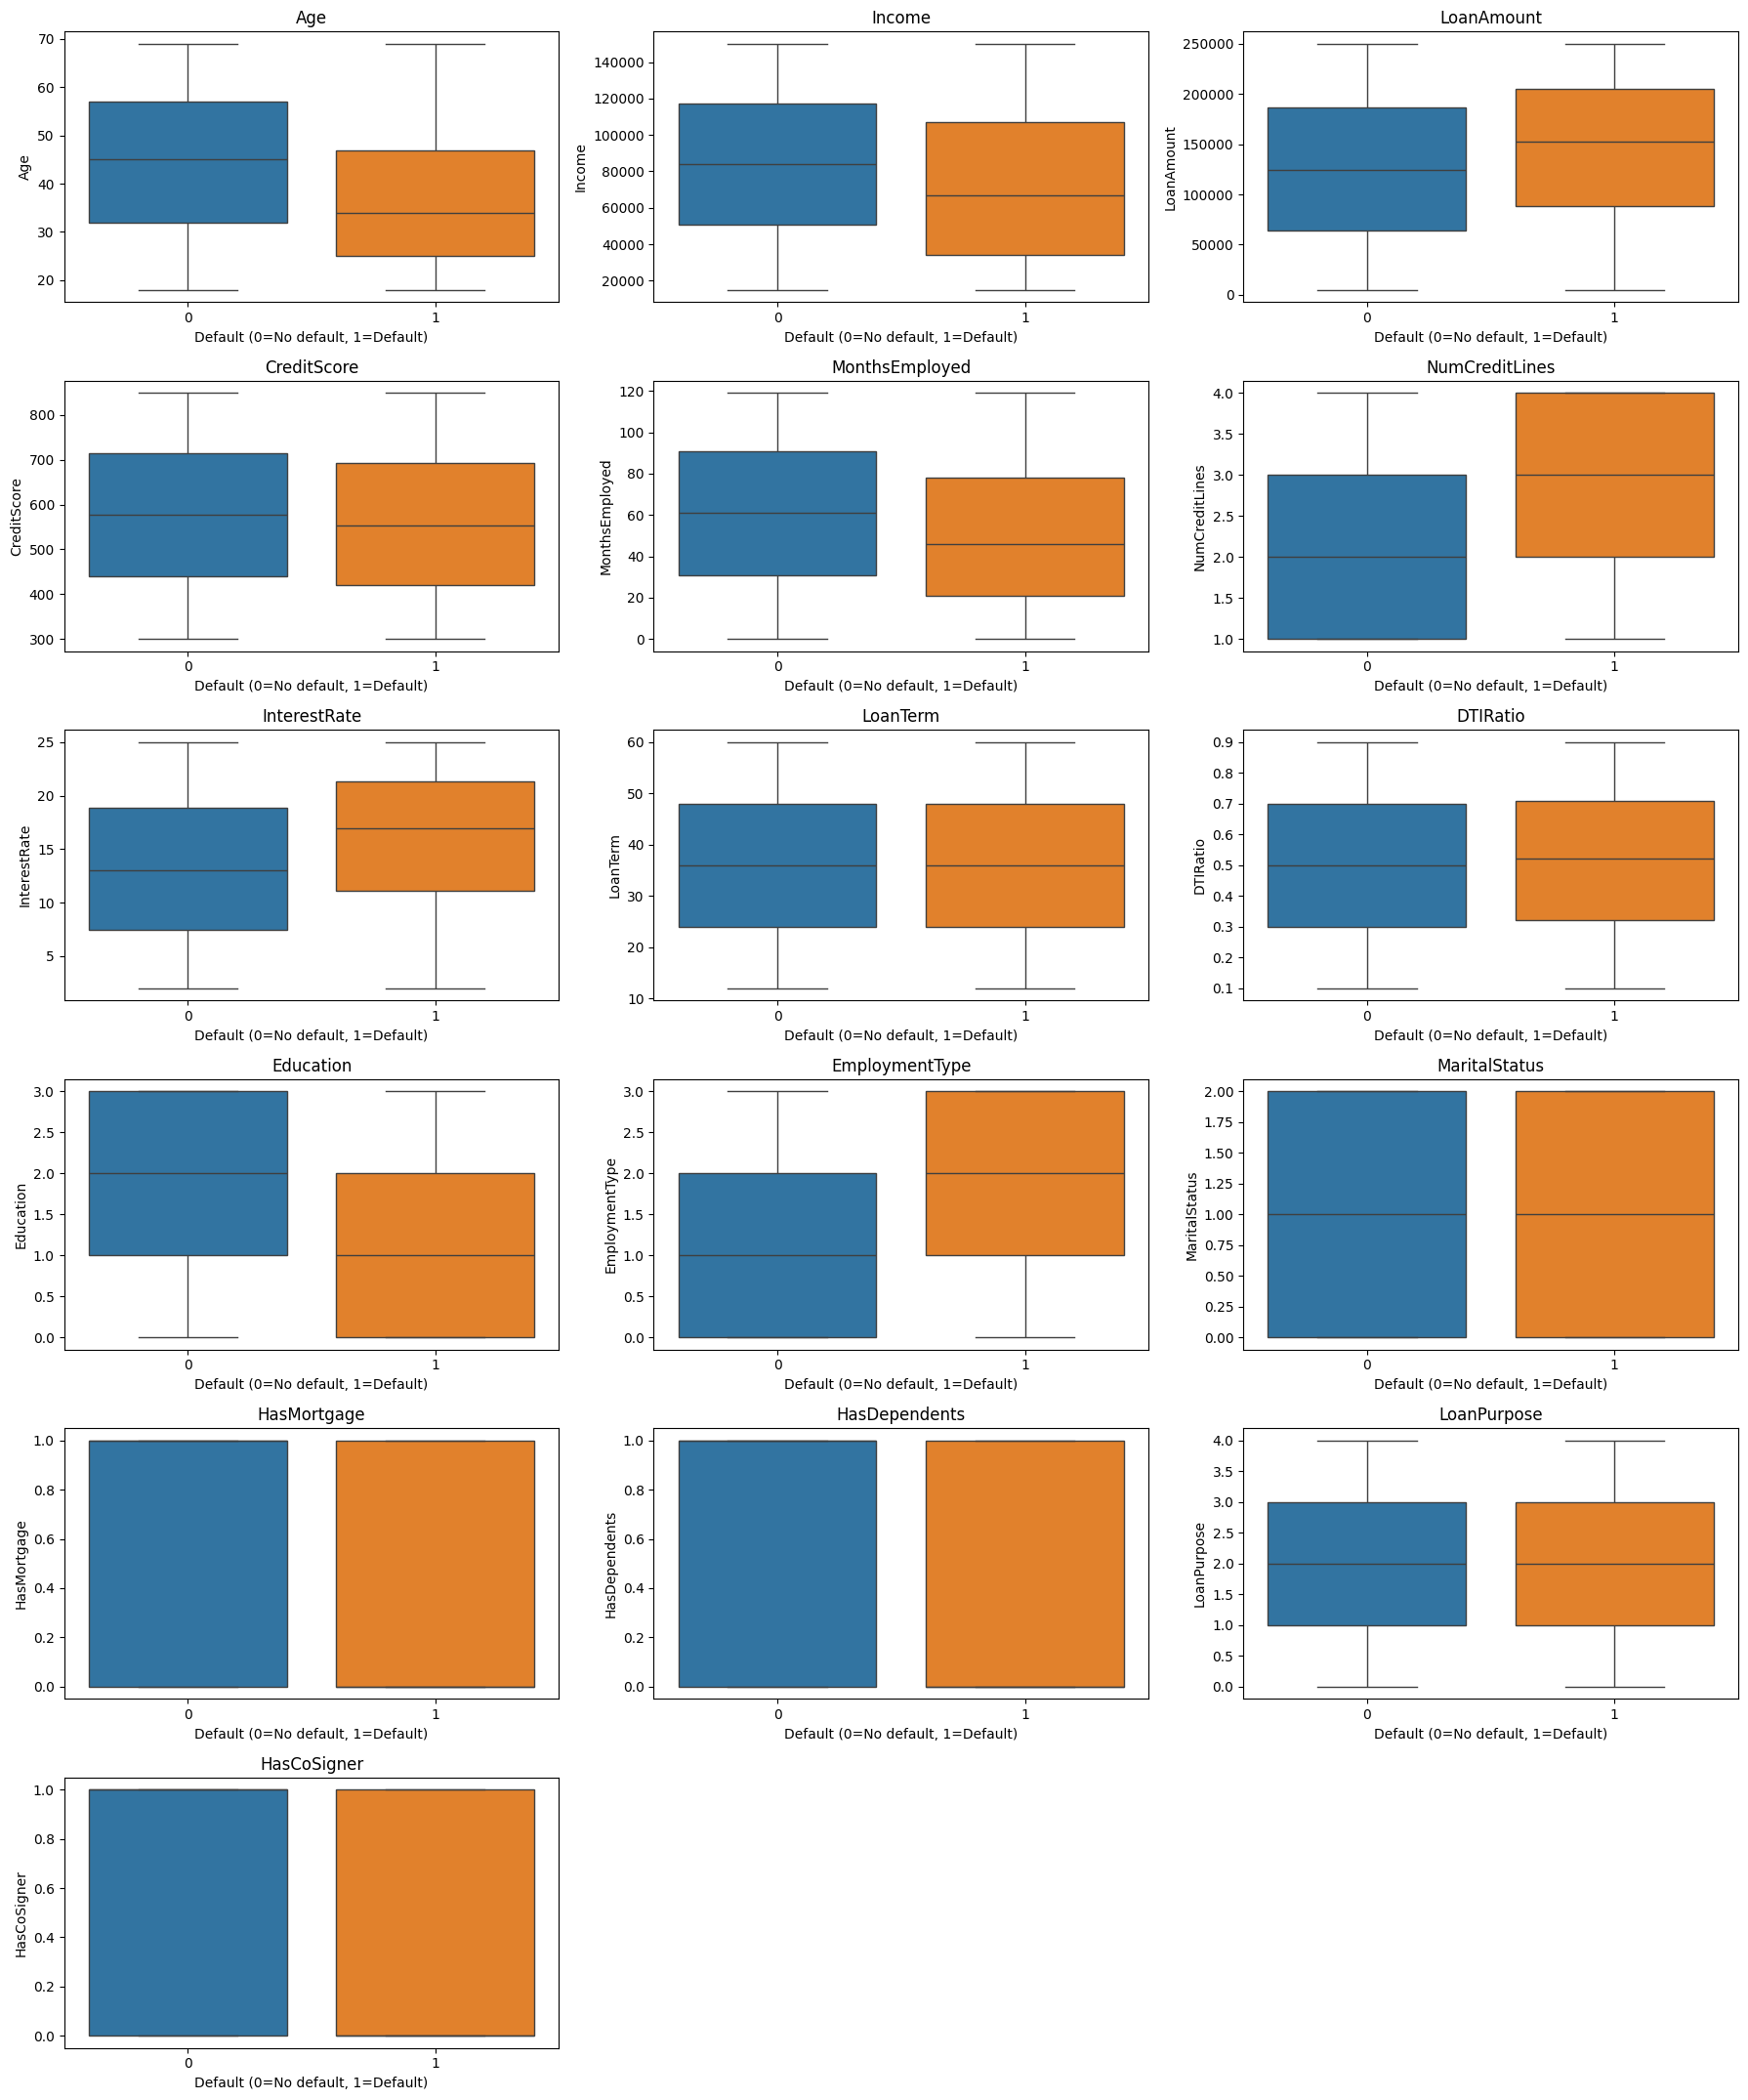

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def boxplots_by_target(df, target="Default", ncols=3, showfliers=False, log_if_skew=True):
    # numeric cols except target
    num_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()
    if target in num_cols:
        num_cols.remove(target)
    if not num_cols:
        print("No numeric columns to plot.")
        return

    n = len(num_cols)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3.6*nrows))
    axes = np.array(axes).reshape(-1)  # flatten even if 1 row

    for i, col in enumerate(num_cols):
        ax = axes[i]
        sns.boxplot(
            x=target, y=col, data=df,
            ax=ax, hue=target, dodge=False, palette={0:"tab:blue",1:"tab:orange"},
            showfliers=showfliers
        )
        ax.legend_.remove()  # keep it clean; axis label explains target
        ax.set_title(col)
        ax.set_xlabel(f"{target} (0=No default, 1=Default)")
        ax.set_ylabel(col)

        # optional: auto log-scale if highly skewed
        if log_if_skew:
            s = df[col].astype(float)
            skew = s.skew()
            if abs(skew) > 1:
                ax.set_yscale("log")
                ax.set_ylabel(f"{col} (log scale)")

    # remove empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# use it:
boxplots_by_target(df, target="Default", ncols=3, showfliers=False)


[LightGBM] [Info] Number of positive: 29653, number of negative: 225694
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1307
[LightGBM] [Info] Number of data points in the train set: 255347, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116128 -> initscore=-2.029617
[LightGBM] [Info] Start training from score -2.029617
           feature  importance
1           Income         407
2       LoanAmount         399
6     InterestRate         375
4   MonthsEmployed         366
3      CreditScore         313
0              Age         293
8         DTIRatio         190
10  EmploymentType         105
9        Education          94
5   NumCreditLines          91
14     LoanPurpose          89
11   MaritalStatus          81
15     HasCoSigner          59
13   H

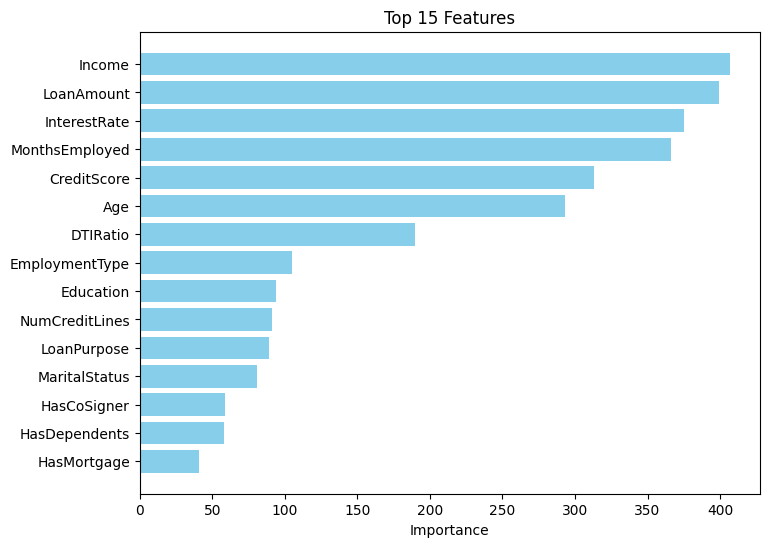

In [ ]:
from lightgbm import LGBMClassifier
import pandas as pd
import matplotlib.pyplot as plt

# X = preprocessed features, y = target
X = df.drop(columns=["Default"])  # drop ID and target
y = df["Default"]

# Train LightGBM
model = LGBMClassifier(random_state=42)
model.fit(X, y)

# Feature importance dataframe
feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values(by="importance", ascending=False)

# Show top features
print(feature_importance)

# Plot top 15 features
top_n = 15
plt.figure(figsize=(8, 6))
plt.barh(feature_importance["feature"][:top_n][::-1],
         feature_importance["importance"][:top_n][::-1],
         color="skyblue")
plt.xlabel("Importance")
plt.title(f"Top {top_n} Features")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Default"]).copy()
y = df["Default"].copy()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print(X_train.shape, X_valid.shape, y_train.mean())


(204277, 16) (51070, 16) 0.11612663197521013


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

rf_tmp = RandomForestClassifier(n_estimators=300, n_jobs=-1,
                                random_state=42, class_weight="balanced_subsample")
rf_tmp.fit(X_train, y_train)

imp = pd.Series(rf_tmp.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top_15_features = imp.head(15).index.tolist()
print("Top 15:", top_15_features)


Top 15: ['InterestRate', 'Age', 'Income', 'LoanAmount', 'MonthsEmployed', 'CreditScore', 'DTIRatio', 'LoanTerm', 'LoanPurpose', 'NumCreditLines', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents']


In [ ]:
from sklearn.preprocessing import MinMaxScaler

X_train_sel = X_train[top_15_features]
X_valid_sel = X_valid[top_15_features]

scaler = MinMaxScaler().fit(X_train_sel)


# Random under sampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_sel, y_train)

print("After undersampling:", y_train_res.value_counts(normalize=True))


After undersampling: Default
0    0.5
1    0.5
Name: proportion, dtype: float64


In [ ]:
X_train_res_scaled = scaler.transform(X_train_res)
X_valid_scaled     = scaler.transform(X_valid_sel)


# LR

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.1, 1, 10],
    "solver": ["liblinear"],
    "fit_intercept": [True, False],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

lr = LogisticRegression(max_iter=5000, class_weight=None, random_state=42)
lr_grid = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring="average_precision",   # PR-AUC
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

lr_grid.fit(X_train_res_scaled, y_train_res)
print("Best CV PR-AUC:", lr_grid.best_score_)
print("Best params:", lr_grid.best_params_)

lr_best = lr_grid.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best CV PR-AUC: 0.7305443027504898
Best params: {'C': 1, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}


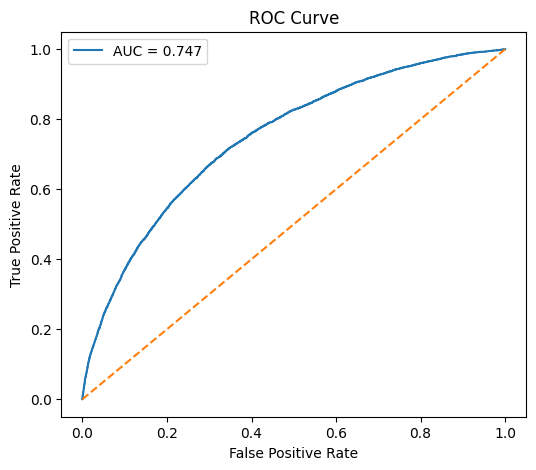

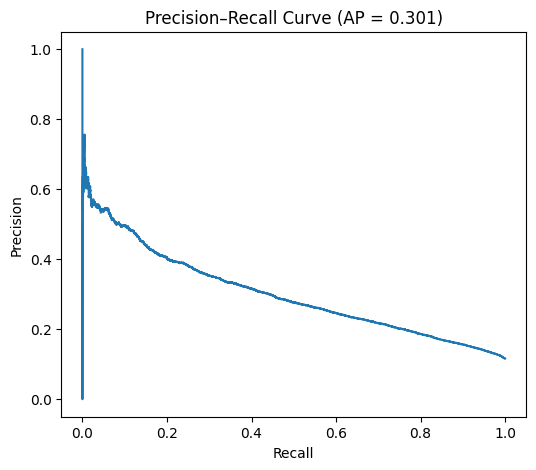

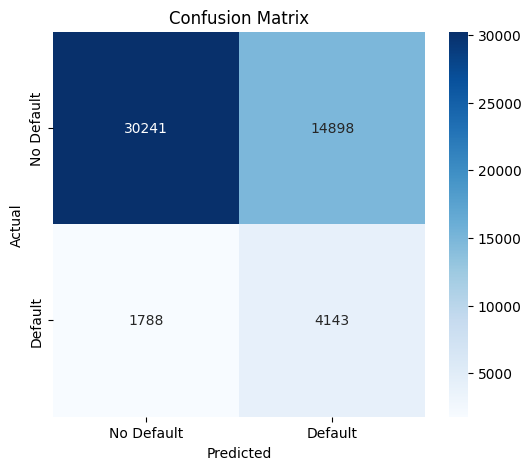

Evaluation Metrics
Accuracy:          0.6733
Balanced Accuracy: 0.6842
Precision (+):     0.2176
Recall (+):        0.6985
F1-score (+):      0.3318
ROC-AUC:           0.7474
PR-AUC (AP):       0.3008

Classification Report:
               precision    recall  f1-score   support

  No Default       0.94      0.67      0.78     45139
     Default       0.22      0.70      0.33      5931

    accuracy                           0.67     51070
   macro avg       0.58      0.68      0.56     51070
weighted avg       0.86      0.67      0.73     51070



In [ ]:
_ = evaluate_model(
    lr_best,
    X_valid_scaled, y_valid,
    class_names=("No Default","Default"),
    plot=True
)


In [ ]:

from sklearn.ensemble import RandomForestClassifier
import pandas as pd

rf_tmp = RandomForestClassifier(n_estimators=300, n_jobs=-1,
                                class_weight="balanced_subsample",
                                random_state=42)
rf_tmp.fit(X_train, y_train)
imp = pd.Series(rf_tmp.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top_15_features = imp.head(15).index.tolist()
print("Top 15:", top_15_features)

X_train_sel = X_train[top_15_features]
X_valid_sel = X_valid[top_15_features]


Top 15: ['InterestRate', 'Age', 'Income', 'LoanAmount', 'MonthsEmployed', 'CreditScore', 'DTIRatio', 'LoanTerm', 'LoanPurpose', 'NumCreditLines', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents']


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_sel, y_train)
print("After undersampling (%):")
print(y_train_res.value_counts(normalize=True))


After undersampling (%):
Default
0    0.5
1    0.5
Name: proportion, dtype: float64


# RF

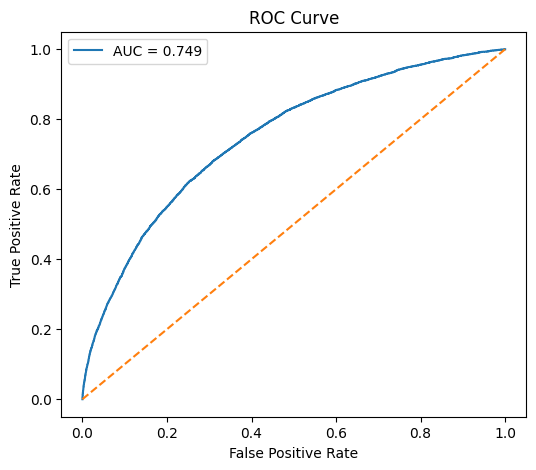

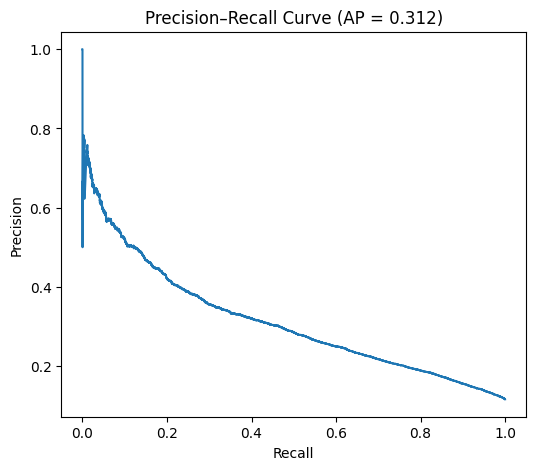

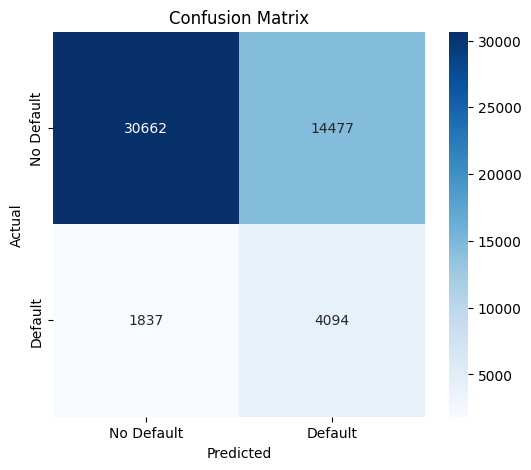

Evaluation Metrics
Accuracy:          0.6806
Balanced Accuracy: 0.6848
Precision (+):     0.2205
Recall (+):        0.6903
F1-score (+):      0.3342
ROC-AUC:           0.7493
PR-AUC (AP):       0.3123

Classification Report:
               precision    recall  f1-score   support

  No Default       0.94      0.68      0.79     45139
     Default       0.22      0.69      0.33      5931

    accuracy                           0.68     51070
   macro avg       0.58      0.68      0.56     51070
weighted avg       0.86      0.68      0.74     51070



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    min_samples_leaf=2,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train_res, y_train_res)

_ = evaluate_model(rf, X_valid_sel, y_valid,
                   class_names=("No Default","Default"), plot=True)


#XGBClassifier

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score

# Initialize XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model on the undersampled and scaled training data
xgb.fit(X_train_res_scaled, y_train_res)

# Evaluate the model on the scaled validation data
y_pred_xgb = xgb.predict(X_valid_scaled)
y_pred_proba_xgb = xgb.predict_proba(X_valid_scaled)[:, 1]

print("XGBoost Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_valid, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_valid, y_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_valid, y_pred_xgb):.4f}")
print(f"F1-score: {f1_score(y_valid, y_pred_xgb):.4f}")
print(f"ROC AUC: {roc_auc_score(y_valid, y_pred_proba_xgb):.4f}")
print(f"Average Precision: {average_precision_score(y_valid, y_pred_proba_xgb):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_valid, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:34:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Model Evaluation:
Accuracy: 0.6711
Precision: 0.2117
Recall: 0.6726
F1-score: 0.3220
ROC AUC: 0.7337
Average Precision: 0.2894

Confusion Matrix:
[[30282 14857]
 [ 1942  3989]]


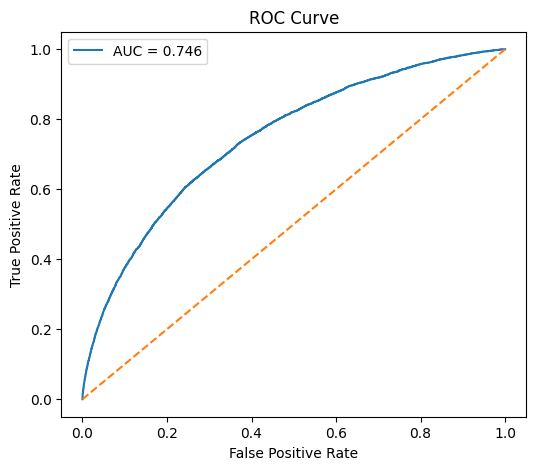

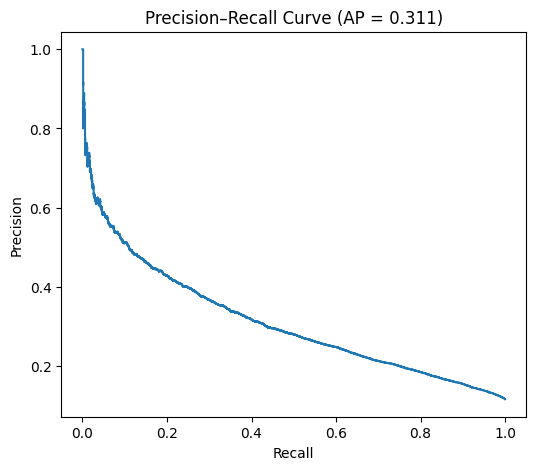

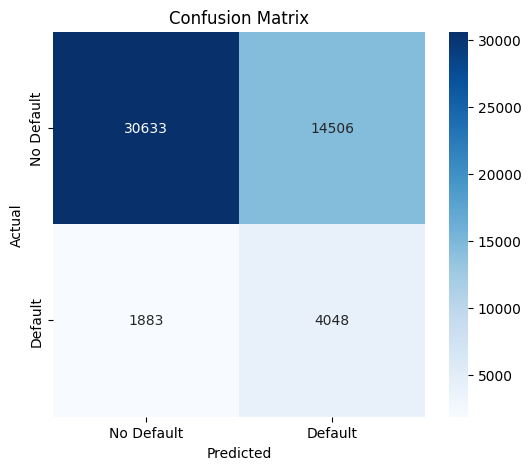

Evaluation Metrics
Accuracy:          0.6791
Balanced Accuracy: 0.6806
Precision (+):     0.2182
Recall (+):        0.6825
F1-score (+):      0.3307
ROC-AUC:           0.7457
PR-AUC (AP):       0.3114

Classification Report:
               precision    recall  f1-score   support

  No Default       0.94      0.68      0.79     45139
     Default       0.22      0.68      0.33      5931

    accuracy                           0.68     51070
   macro avg       0.58      0.68      0.56     51070
weighted avg       0.86      0.68      0.74     51070



In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier



X_train_sel = X_train[top_15_features]
X_valid_sel = X_valid[top_15_features]

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_sel, y_train)

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    tree_method="hist",
    learning_rate=0.07,
    n_estimators=700,
    max_depth=5,
    min_child_weight=5,
    subsample=0.9,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0.0,
    reg_lambda=5.0,
    scale_pos_weight=1,
    n_jobs=-1,
    random_state=42
)

xgb.fit(X_train_res, y_train_res)

_ = evaluate_model(
    xgb,
    X_valid_sel, y_valid,
    class_names=("No Default","Default"),
    plot=True
)


# **class weight**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

X_full = df.drop(columns=["Default"]).copy()
y_full = df["Default"].astype(int).copy()

X_train_full, X_valid_full, y_train_full, y_valid_full = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_valid_scaled = scaler.transform(X_valid_full)

classes = np.array([0, 1])
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_full)
class_weight = {int(c): float(w) for c, w in zip(classes, weights)}
class_weight


{0: 0.5656918944365983, 1: 4.30564454936346}

# NN

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)

def build_mlp(input_dim):
    inputs = tf.keras.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(128, activation="relu")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Dense(32, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.AUC(curve="PR", name="pr_auc"),
            tf.keras.metrics.AUC(curve="ROC", name="roc_auc"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ],
    )
    return model

mlp = build_mlp(input_dim=X_train_scaled.shape[1])
mlp.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,441 (52.50 KB)

 Trainable params: 12,993 (50.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_pr_auc", mode="max",
                                     patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_pr_auc", mode="max",
                                         factor=0.5, patience=3, min_lr=1e-5, verbose=1),
]

history = mlp.fit(
    X_train_scaled, y_train_full,
    validation_data=(X_valid_scaled, y_valid_full),
    epochs=50,
    batch_size=1024,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.7379 - pr_auc: 0.1698 - precision: 0.1536 - recall: 0.6064 - roc_auc: 0.6156 - val_loss: 0.5487 - val_pr_auc: 0.2928 - val_precision: 0.2819 - val_recall: 0.4628 - val_roc_auc: 0.7439 - learning_rate: 0.0010
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.6260 - pr_auc: 0.2458 - precision: 0.1954 - recall: 0.6666 - roc_auc: 0.7105 - val_loss: 0.5656 - val_pr_auc: 0.3054 - val_precision: 0.2296 - val_recall: 0.6619 - val_roc_auc: 0.7512 - learning_rate: 0.0010
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.6085 - pr_auc: 0.2671 - precision: 0.2046 - recall: 0.6824 - roc_auc: 0.7287 - val_loss: 0.5806 - val_pr_auc: 0.3111 - val_precision: 0.2238 - val_recall: 0.6931 - val_roc_auc: 0.7531 - learning_rate: 0.0010
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.6018 - pr_auc: 0.2766 - precision: 0.2106 - recall: 0.6848 - roc_auc: 0.7365 - val_loss: 0.5746 - val_pr_auc: 0.3152 - val_

# **NN with more layres & Class Weight**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 0) فصل الهدف
X = df.drop(columns=["Default"]).copy()
y = df["Default"].astype(int).copy()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

X_train_oh = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_valid_oh = pd.get_dummies(X_valid, columns=cat_cols, drop_first=True)
X_valid_oh = X_valid_oh.reindex(columns=X_train_oh.columns, fill_value=0)

orig_num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
num_cols = [c for c in orig_num_cols if c in X_train_oh.columns]

scaler = MinMaxScaler().fit(X_train_oh[num_cols])
X_train_oh[num_cols] = scaler.transform(X_train_oh[num_cols])
X_valid_oh[num_cols] = scaler.transform(X_valid_oh[num_cols])

print("Train shape:", X_train_oh.shape, " | Valid shape:", X_valid_oh.shape)


Train shape: (204277, 16)  | Valid shape: (51070, 16)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

y_tr = np.asarray(y_train).ravel().astype(int)
classes = np.array([0, 1], dtype=int)

weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_tr)
class_weight = dict(zip(classes, weights))
print("Class weights:", class_weight)


Class weights: {np.int64(0): np.float64(0.5656918944365983), np.int64(1): np.float64(4.30564454936346)}


In [ ]:
import tensorflow as tf
tf.random.set_seed(42)

def build_mlp_big(input_dim, lr=3e-4, l2=2e-4):
    reg = tf.keras.regularizers.l2(l2)
    he  = tf.keras.initializers.HeNormal()

    inp = tf.keras.Input(shape=(input_dim,))

    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=reg,
                              kernel_initializer=he)(inp)
    x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.Dropout(0.35)(x)

    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=reg,
                              kernel_initializer=he)(x)
    x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.Dropout(0.35)(x)

    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=reg,
                              kernel_initializer=he)(x)
    x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.Dropout(0.30)(x)

    x = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=reg,
                              kernel_initializer=he)(x)
    x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=reg,
                              kernel_initializer=he)(x)
    x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.Dropout(0.20)(x)

    out = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.AUC(curve="PR",  name="pr_auc"),
            tf.keras.metrics.AUC(curve="ROC", name="roc_auc"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ],
    )
    return model

mlp = build_mlp_big(X_train_oh.shape[1])
mlp.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,905 (984.00 KB)

 Trainable params: 249,473 (974.50 KB)

 Non-trainable params: 2,432 (9.50 KB)

In [ ]:
import tensorflow as tf

ckpt_best = tf.keras.callbacks.ModelCheckpoint(
    "mlp_best.keras",
    monitor="val_pr_auc",
    mode="max",
    save_best_only=True,
    verbose=1
)

ckpt_last = tf.keras.callbacks.ModelCheckpoint(
    "mlp_last.keras",
    monitor="val_pr_auc",
    mode="max",
    save_best_only=False,
    verbose=0
)

early = tf.keras.callbacks.EarlyStopping(
    monitor="val_pr_auc", mode="max",
    patience=6, restore_best_weights=True
)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_pr_auc", mode="max",
    factor=0.5, patience=3, min_lr=1e-5, verbose=1
)

history = mlp.fit(
    X_train_oh.values, y_train.values,
    validation_data=(X_valid_oh.values, y_valid.values),
    epochs=100,
    batch_size=4096,
    class_weight=class_weight,
    callbacks=[early, plateau, ckpt_best, ckpt_last],
    verbose=1
)


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 1.3209 - pr_auc: 0.1478 - precision: 0.1358 - recall: 0.5713 - roc_auc: 0.5722
Epoch 1: val_pr_auc improved from -inf to 0.24710, saving model to mlp_best.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 296ms/step - loss: 1.3199 - pr_auc: 0.1481 - precision: 0.1361 - recall: 0.5720 - roc_auc: 0.5728 - val_loss: 1.0023 - val_pr_auc: 0.2471 - val_precision: 0.2797 - val_recall: 0.2920 - val_roc_auc: 0.6972 - learning_rate: 3.0000e-04
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 1.1946 - pr_auc: 0.1927 - precision: 0.1620 - recall: 0.6337 - roc_auc: 0.6471
Epoch 2: val_pr_auc improved from 0.24710 to 0.27696, saving model to mlp_best.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 268ms/step - loss: 1.1945 - pr_auc: 0.1928 - precision: 0.1620 - recall: 0.6338 - roc_auc: 0.6473 - val_loss: 0.9784 - val_pr_auc: 0.2770 - val_precision: 0.2973 - val_recall: 0.3519 - val_roc_auc: 0.7274 - learning_rate: 3.0000e-04
Epoch 3/100
50/50 ━━━━━━━

In [ ]:
import tensorflow as tf

# 1) حمّل أفضل وزن، لكن بدون compile عشان نعيده بإيدنا
ft = tf.keras.models.load_model("mlp_best.keras", compile=False)

# 2) أعد الـcompile بـ LR أصغر (فين-تيون)
ft.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(curve="PR",  name="pr_auc"),
        tf.keras.metrics.AUC(curve="ROC", name="roc_auc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ],
)

# 3) كولباكس للفين-تيون
more_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_pr_auc", mode="max",
                                     patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_pr_auc", mode="max",
                                         factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.ModelCheckpoint("mlp_best_ft.keras",
                                       monitor="val_pr_auc", mode="max",
                                       save_best_only=True, verbose=1),
]

# 4) كمّل من الأوزان الحالية (Fine-tune)
history_ft = ft.fit(
    X_train_oh.values, y_train.values,
    validation_data=(X_valid_oh.values, y_valid.values),
    epochs=40,                # زوّد/قلّل حسب ما تشوف val_pr_auc
    batch_size=4096,
    class_weight=class_weight,
    callbacks=more_callbacks,
    verbose=1
)


Epoch 1/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 0.7050 - pr_auc: 0.3056 - precision: 0.2202 - recall: 0.6950 - roc_auc: 0.7541
Epoch 1: val_pr_auc improved from -inf to 0.32916, saving model to mlp_best_ft.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 284ms/step - loss: 0.7051 - pr_auc: 0.3057 - precision: 0.2202 - recall: 0.6950 - roc_auc: 0.7541 - val_loss: 0.6987 - val_pr_auc: 0.3292 - val_precision: 0.2250 - val_recall: 0.6977 - val_roc_auc: 0.7580 - learning_rate: 1.0000e-04
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 0.7033 - pr_auc: 0.3057 - precision: 0.2195 - recall: 0.6969 - roc_auc: 0.7533
Epoch 2: val_pr_auc improved from 0.32916 to 0.32930, saving model to mlp_best_ft.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 269ms/step - loss: 0.7033 - pr_auc: 0.3058 - precision: 0.2195 - recall: 0.6969 - roc_auc: 0.7533 - val_loss: 0.6952 - val_pr_auc: 0.3293 - val_precision: 0.2247 - val_recall: 0.6974 - val_roc_auc: 0.7580 - learning_rate: 1.0000e-04
Epoch 3/40
50/50 ━━━━

In [ ]:
# لو عندك "mlp_best_ft.keras" من الفاين-تيون استخدمه
BEST_MODEL_PATH = "mlp_best_ft.keras"   # أو "mlp_best.keras" لو ده المتوفر

import tensorflow as tf
best = tf.keras.models.load_model(BEST_MODEL_PATH)  # للتأكّد إنه موجود
print("Loaded:", BEST_MODEL_PATH)


Loaded: mlp_best_ft.keras


In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve

def threshold_max_f1(y_true, y_score):
    p, r, thr = precision_recall_curve(y_true, y_score)
    f1 = 2 * p * r / (p + r + 1e-12)
    idx = np.nanargmax(f1[:-1])      # آخر عنصر في p/r مالوش threshold
    return float(thr[idx]), float(p[idx]), float(r[idx]), float(f1[idx])

def threshold_for_precision(y_true, y_score, target_p=0.35):
    p, r, thr = precision_recall_curve(y_true, y_score)
    mask = p[:-1] >= target_p
    if not np.any(mask): return None, None, None, None
    idx = np.where(mask)[0][0]
    return float(thr[idx]), float(p[idx]), float(r[idx]), float(2*p[idx]*r[idx]/(p[idx]+r[idx]+1e-12))

def threshold_for_recall(y_true, y_score, target_r=0.80):
    p, r, thr = precision_recall_curve(y_true, y_score)
    mask = r[:-1] >= target_r
    if not np.any(mask): return None, None, None, None
    idx = np.where(mask)[0][-1]
    return float(thr[idx]), float(p[idx]), float(r[idx]), float(2*p[idx]*r[idx]/(p[idx]+r[idx]+1e-12))


In [ ]:
# احتمالات الكلاس الإيجابي من أفضل موديلك
y_score = best.predict(X_valid_oh.values, verbose=0).ravel().astype(float)

# اختيار 1: أفضل F1
thr, p, r, f1 = threshold_max_f1(y_valid.values, y_score)
print(f"Best-F1 threshold = {thr:.4f} | P={p:.3f}, R={r:.3f}, F1={f1:.3f}")

# # اختيار 2 (بديل): Precision مستهدف
# thr, p, r, f1 = threshold_for_precision(y_valid.values, y_score, target_p=0.35)

# # اختيار 3 (بديل): Recall مستهدف
# thr, p, r, f1 = threshold_for_recall(y_valid.values, y_score, target_r=0.80)

# احفظ العتبة
with open("threshold.txt", "w") as f:
    f.write(str(thr))
print("Saved threshold.txt")


Best-F1 threshold = 0.6213 | P=0.296, R=0.511, F1=0.375
Saved threshold.txt


In [ ]:
import json, joblib

# 1) الموديل (عندك بالفعل BEST_MODEL_PATH؛ ممكن تعمل نسخة باسم ثابت)
best.save("mlp_final.keras")

# 2) السكيلر
joblib.dump(scaler, "minmax_scaler.joblib")

# 3) ترتيب أعمدة الـone-hot + القوايم
with open("oh_columns.json", "w") as f:
    json.dump(list(X_train_oh.columns), f)

with open("cat_cols.json", "w") as f:
    json.dump(cat_cols, f)

with open("num_cols.json", "w") as f:
    json.dump(num_cols, f)

print("Saved: mlp_final.keras, minmax_scaler.joblib, oh_columns.json, cat_cols.json, num_cols.json")


Saved: mlp_final.keras, minmax_scaler.joblib, oh_columns.json, cat_cols.json, num_cols.json


In [ ]:
import json, joblib, numpy as np, pandas as pd, tensorflow as tf

def load_artifacts():
    model  = tf.keras.models.load_model("mlp_final.keras")
    scaler = joblib.load("minmax_scaler.joblib")
    with open("oh_columns.json") as f: oh_cols = json.load(f)
    with open("cat_cols.json") as f:   cat_cols = json.load(f)
    with open("num_cols.json") as f:   num_cols = json.load(f)
    with open("threshold.txt") as f:   THR = float(f.read().strip())
    return model, scaler, oh_cols, cat_cols, num_cols, THR

def preprocess(df_raw, scaler, oh_cols, cat_cols, num_cols):
    X_oh = pd.get_dummies(df_raw.copy(), columns=cat_cols, drop_first=True)
    X_oh = X_oh.reindex(columns=oh_cols, fill_value=0)
    X_oh[num_cols] = scaler.transform(X_oh[num_cols])
    return X_oh

def predict_df(df_raw: pd.DataFrame) -> pd.DataFrame:
    model, scaler, oh_cols, cat_cols, num_cols, THR = load_artifacts()
    Xp = preprocess(df_raw, scaler, oh_cols, cat_cols, num_cols)
    proba = model.predict(Xp.values, verbose=0).ravel()
    pred  = (proba >= THR).astype(int)
    out = df_raw.copy()
    out["default_proba"] = proba
    out["default_pred"]  = pred
    return out

# new_rows = df.drop(columns=["Default"]).sample(5, random_state=42)
# predict_df(new_rows)


In [ ]:
# 1) سكربت inference جاهز
inference_code = """
import json, joblib, numpy as np, pandas as pd, tensorflow as tf

MODEL_PATH = "mlp_final.keras"  # أو mlp_best_ft.keras لو بتفضّل

def load_artifacts():
    model  = tf.keras.models.load_model(MODEL_PATH)
    scaler = joblib.load("minmax_scaler.joblib")
    with open("oh_columns.json") as f: oh_cols = json.load(f)
    with open("cat_cols.json") as f:   cat_cols = json.load(f)
    with open("num_cols.json") as f:   num_cols = json.load(f)
    with open("threshold.txt") as f:   THR = float(f.read().strip())
    return model, scaler, oh_cols, cat_cols, num_cols, THR

def preprocess(df_raw: pd.DataFrame, scaler, oh_cols, cat_cols, num_cols):
    X_oh = pd.get_dummies(df_raw.copy(), columns=cat_cols, drop_first=True)
    X_oh = X_oh.reindex(columns=oh_cols, fill_value=0)
    X_oh[num_cols] = scaler.transform(X_oh[num_cols])
    return X_oh

def predict_df(df_raw: pd.DataFrame) -> pd.DataFrame:
    model, scaler, oh_cols, cat_cols, num_cols, THR = load_artifacts()
    Xp = preprocess(df_raw, scaler, oh_cols, cat_cols, num_cols)
    proba = model.predict(Xp.values, verbose=0).ravel()
    pred  = (proba >= THR).astype(int)
    out = df_raw.copy()
    out["default_proba"] = proba
    out["default_pred"]  = pred
    return out
"""
with open("inference.py","w") as f:
    f.write(inference_code)

# 2) لو لسه ماعملتش نسخة باسم ثابت:
import tensorflow as tf, joblib, json, os, shutil
best_path = "mlp_best_ft.keras" if os.path.exists("mlp_best_ft.keras") else "mlp_best.keras"
best = tf.keras.models.load_model(best_path)
best.save("mlp_final.keras")  # اسم ثابت

# 3) اجمع كل الملفات في فولدر
os.makedirs("deploy_bundle", exist_ok=True)
to_pack = [
    "mlp_final.keras",
    "mlp_best_ft.keras" if os.path.exists("mlp_best_ft.keras") else None,
    "minmax_scaler.joblib",
    "oh_columns.json", "cat_cols.json", "num_cols.json",
    "threshold.txt",
    "inference.py",
]
to_pack = [p for p in to_pack if p and os.path.exists(p)]
for p in to_pack:
    shutil.copy2(p, os.path.join("deploy_bundle", os.path.basename(p)))

# 4) اعمل ZIP
import shutil
shutil.make_archive("deploy_bundle", "zip", "deploy_bundle")
print(" Ready: deploy_bundle.zip with", to_pack)


✅ Ready: deploy_bundle.zip with ['mlp_final.keras', 'mlp_best_ft.keras', 'minmax_scaler.joblib', 'oh_columns.json', 'cat_cols.json', 'num_cols.json', 'threshold.txt', 'inference.py']


In [ ]:
try:
    from google.colab import files
    files.download("deploy_bundle.zip")
except Exception:
    print("Saved locally at ./deploy_bundle.zip — حمّله يدويًا لو مش على Colab.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# from sklearn.model_selection import train_test_split

# # Select features (all columns except the target) and target
# X = df.drop(columns=["Default"])
# y = df["Default"]

# # Split into train & validation sets (stratified to preserve ratio)
# X_train, X_valid, y_train, y_valid = train_test_split(
#     X, y,
#     test_size=0.2,  # 20% for validation
#     stratify=y,     # keep the same proportion of default/non-default
#     random_state=42 # for reproducibility
# )

# print("Shape of training data (X_train, y_train):", X_train.shape, y_train.shape)
# print("Shape of validation data (X_valid, y_valid):", X_valid.shape, y_valid.shape)
# print("\nTarget distribution in training set:", y_train.value_counts(normalize=True))
# print("Target distribution in validation set:", y_valid.value_counts(normalize=True))

Shape of training data (X_train, y_train): (204277, 16) (204277,)
Shape of validation data (X_valid, y_valid): (51070, 16) (51070,)

Target distribution in training set: Default
0    0.883873
1    0.116127
Name: proportion, dtype: float64
Target distribution in validation set: Default
0    0.883865
1    0.116135
Name: proportion, dtype: float64


In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# # Apply MinMaxScaler to the features
# scaler = MinMaxScaler()

# # Fit the scaler on the training data and transform both training and validation data
# X_train_scaled = scaler.fit_transform(X_train)

Top 15 features: ['Income', 'LoanAmount', 'InterestRate', 'MonthsEmployed', 'CreditScore', 'Age', 'DTIRatio', 'EmploymentType', 'Education', 'NumCreditLines', 'LoanPurpose', 'MaritalStatus', 'HasCoSigner', 'HasDependents', 'HasMortgage']
Shape of scaled training data: (204277, 15)
Shape of scaled validation data: (51070, 15)


In [ ]:
# from sklearn.model_selection import train_test_split

# # Select top 10 features from your importance ranking
# top_10_features = feature_importance["feature"].head(10).tolist()
# print("Top 10 features:", top_10_features)

# X = df[top_10_features]
# y = df["Default"]

# # Split into train & validation sets (stratified to preserve ratio)
# X_train, X_valid, y_train, y_valid = train_test_split(
#     X, y,
#     test_size=0.2,
#     stratify=y,
#     random_state=42
# )

# print("Before undersampling:", y_train.value_counts(normalize=True))


Top 10 features: ['Income', 'LoanAmount', 'InterestRate', 'MonthsEmployed', 'CreditScore', 'Age', 'DTIRatio', 'EmploymentType', 'Education', 'NumCreditLines']
Before undersampling: Default
0    0.883873
1    0.116127
Name: proportion, dtype: float64


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Apply RandomUnderSampler ONLY on training set
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

print("After undersampling:", y_train_res.value_counts(normalize=True))


After undersampling: Default
0    0.5
1    0.5
Name: proportion, dtype: float64


#sacler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

# 1) fit scaler on ORIGINAL train
scaler = MinMaxScaler().fit(X_train)

# 2) undersample train
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# 3) transform
X_train_res_scaled = scaler.transform(X_train_res)
X_valid_scaled     = scaler.transform(X_valid)


In [ ]:
print(X_train_res_scaled.shape)
print(X_valid_scaled.shape)

(47444, 10)
(51070, 10)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, average_precision_score, precision_recall_curve,
    confusion_matrix, classification_report
)

def evaluate_model(model, X_test, y_test, *,
                   pos_label=1,
                   class_names=("No Default", "Default"),
                   plot=True):
    """
    Evaluate a classifier on an imbalanced dataset.

    Parameters
    ----------
    model : fitted estimator supporting predict(), and ideally predict_proba() or decision_function()
    X_test : array-like
    y_test : array-like
    pos_label : label considered the positive class (default=1)
    class_names : tuple[str, str] for confusion-matrix axes (neg_name, pos_name)
    plot : bool, whether to draw ROC/PR curves and the confusion matrix

    Returns
    -------
    dict with metrics and (optionally) curves
    """

    # ---- Get scores/probabilities for the positive class ----
    y_score = None
    if hasattr(model, "predict_proba"):
        # index the column corresponding to pos_label
        # works when classes_ may be [0,1] or [1,0]
        pos_idx = np.where(model.classes_ == pos_label)[0][0]
        y_score = model.predict_proba(X_test)[:, pos_idx]
    elif hasattr(model, "decision_function"):
        # raw scores; still fine for ROC/PR
        y_score = model.decision_function(X_test)

    # ---- Predictions (threshold 0.5 if we have probabilities) ----
    if y_score is not None and hasattr(model, "predict_proba"):
        y_pred = (y_score >= 0.5).astype(int) if pos_label == 1 else (y_score >= 0.5).astype(model.classes_.dtype)
    else:
        # fall back to model's discrete predictions
        y_pred = model.predict(X_test)

    # ---- Metrics ----
    acc  = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=pos_label, zero_division=0)
    rec  = recall_score(y_test, y_pred, pos_label=pos_label, zero_division=0)
    f1   = f1_score(y_test, y_pred, pos_label=pos_label, zero_division=0)

    roc_auc = average_prec = None
    fpr = tpr = roc_thresh = None
    pr_prec = pr_rec = pr_thresh = None

    if y_score is not None:
        # ROC-AUC
        try:
            roc_auc = roc_auc_score(y_test, y_score)
            fpr, tpr, roc_thresh = roc_curve(y_test, y_score, pos_label=pos_label)
        except ValueError:
            pass
        # PR-AUC (Average Precision)
        average_prec = average_precision_score(y_test, y_score, pos_label=pos_label)
        pr_prec, pr_rec, pr_thresh = precision_recall_curve(y_test, y_score, pos_label=pos_label)

    cm = confusion_matrix(y_test, y_pred, labels=[0, pos_label])
    report = classification_report(y_test, y_pred, target_names=class_names, zero_division=0)

    # ---- Plots ----
    if plot:
        if y_score is not None and roc_auc is not None:
            plt.figure(figsize=(6,5))
            plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
            plt.plot([0,1],[0,1], linestyle="--")
            plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
            plt.title("ROC Curve"); plt.legend(); plt.show()

            plt.figure(figsize=(6,5))
            plt.plot(pr_rec, pr_prec)  # x=recall, y=precision
            plt.xlabel("Recall"); plt.ylabel("Precision")
            plt.title(f"Precision–Recall Curve (AP = {average_prec:.3f})")
            plt.show()

        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
        plt.show()

    # ---- Print summary ----
    print("Evaluation Metrics")
    print(f"Accuracy:          {acc:.4f}")
    print(f"Balanced Accuracy: {bacc:.4f}")
    print(f"Precision (+):     {prec:.4f}")
    print(f"Recall (+):        {rec:.4f}")
    print(f"F1-score (+):      {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC:           {roc_auc:.4f}")
        print(f"PR-AUC (AP):       {average_prec:.4f}")
    print("\nClassification Report:\n", report)

    return {
        "accuracy": acc,
        "balanced_accuracy": bacc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc,
        "pr_auc": average_prec,
        "confusion_matrix": cm,
        "classification_report": report,
        "roc_curve": (fpr, tpr, roc_thresh),
        "pr_curve": (pr_prec, pr_rec, pr_thresh),
        "scores": y_score,
        "preds": y_pred
    }


# logistic regression

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

lr = Pipeline([
    ("scaler", StandardScaler()),                      # بس علشان الميّزات تتظبط
    ("clf", LogisticRegression(max_iter=5000,          # يكفي للتقارب
                               class_weight="balanced",
                               solver="lbfgs",
                               random_state=42))
])


lr.fit(X_train_res, y_train_res)   # وفي الحالة دي شيّل class_weight من الموديل لو حابب


Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    random_state=42))])

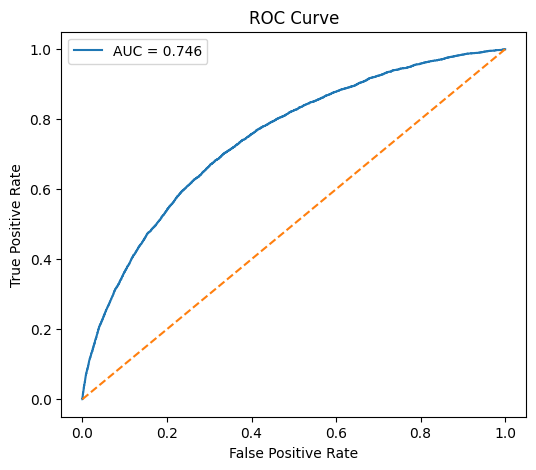

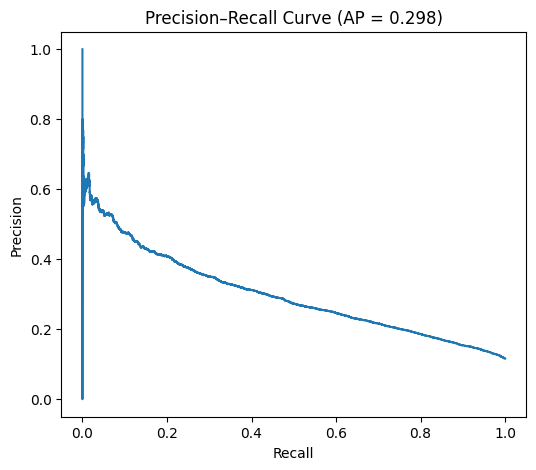

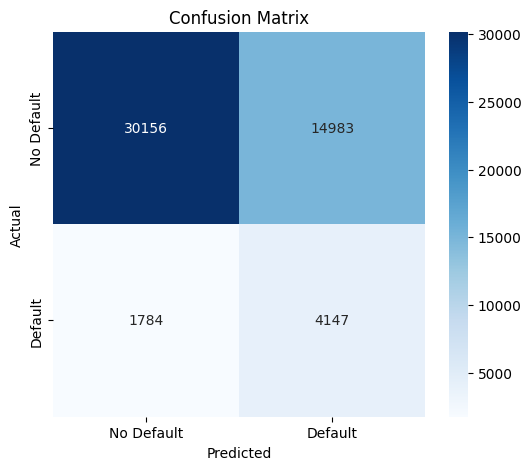

Evaluation Metrics
Accuracy:          0.6717
Balanced Accuracy: 0.6836
Precision (+):     0.2168
Recall (+):        0.6992
F1-score (+):      0.3310
ROC-AUC:           0.7456
PR-AUC (AP):       0.2981

Classification Report:
               precision    recall  f1-score   support

  No Default       0.94      0.67      0.78     45139
     Default       0.22      0.70      0.33      5931

    accuracy                           0.67     51070
   macro avg       0.58      0.68      0.56     51070
weighted avg       0.86      0.67      0.73     51070



In [ ]:
_ = evaluate_model(lr, X_valid, y_valid, class_names=("No Default","Default"), plot=True)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best CV PR-AUC: 0.7277086773106379
Best params: {'C': 0.1, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}


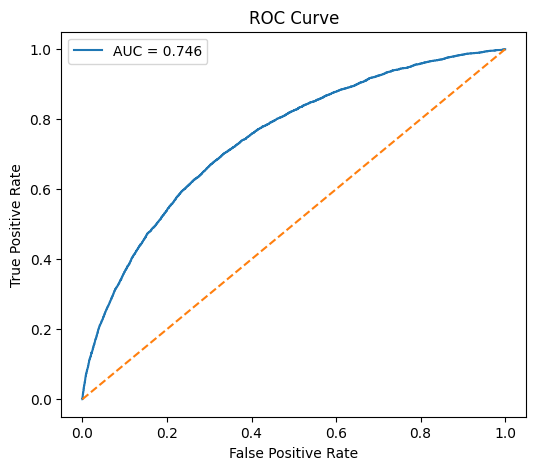

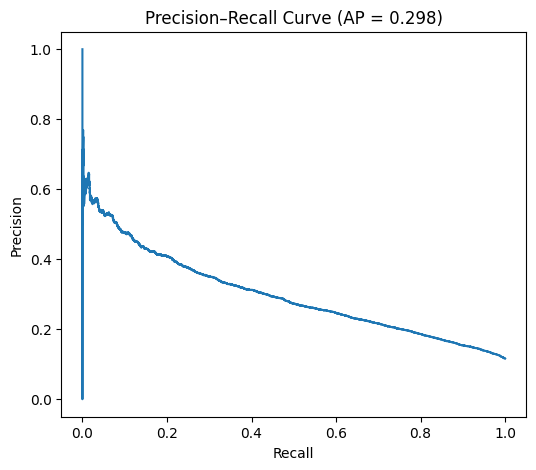

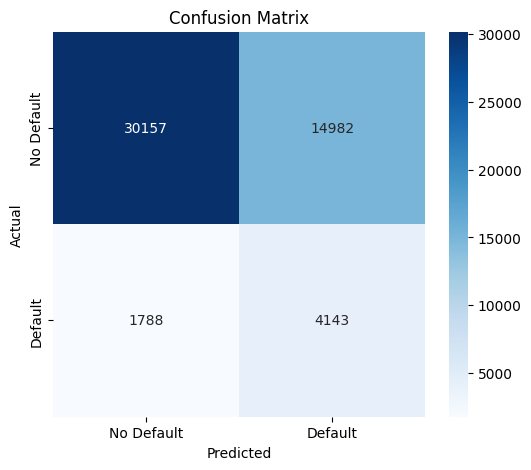

Evaluation Metrics
Accuracy:          0.6716
Balanced Accuracy: 0.6833
Precision (+):     0.2166
Recall (+):        0.6985
F1-score (+):      0.3307
ROC-AUC:           0.7456
PR-AUC (AP):       0.2980

Classification Report:
               precision    recall  f1-score   support

  No Default       0.94      0.67      0.78     45139
     Default       0.22      0.70      0.33      5931

    accuracy                           0.67     51070
   macro avg       0.58      0.68      0.56     51070
weighted avg       0.86      0.67      0.73     51070



In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# ---- 1) Fit scaler on ORIGINAL training set (no leakage)
scaler = MinMaxScaler()
scaler.fit(X_train)

# ---- 2) Random undersample the TRAIN set only
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# ---- 3) Transform undersampled train + untouched valid using the same scaler
X_train_res_scaled = scaler.transform(X_train_res)
X_valid_scaled     = scaler.transform(X_valid)

# ---- 4) Logistic Regression + small grid (no class_weight since we undersampled)
param_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.1, 1, 10],
    "solver": ["liblinear"],
    "fit_intercept": [True, False],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

lr = LogisticRegression(max_iter=5000, class_weight=None, random_state=42)
lr_grid = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring="average_precision",   # PR-AUC
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

# ---- 5) Train on UNDERSAMPLED + SCALED data
lr_grid.fit(X_train_res_scaled, y_train_res)

print("Best CV PR-AUC:", lr_grid.best_score_)
print("Best params:", lr_grid.best_params_)

lr_best = lr_grid.best_estimator_

# ---- 6) Evaluate on the SCALED validation set
_ = evaluate_model(
    lr_best,
    X_valid_scaled, y_valid,
    class_names=("No Default","Default"),
    plot=True
)


#Random Forest

Fitting 2 folds for each of 8 candidates, totalling 16 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Best CV PR-AUC: nan
Best params: {'max_depth': None, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 421}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


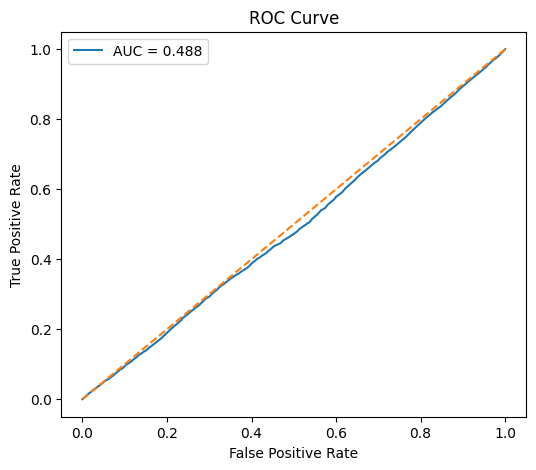

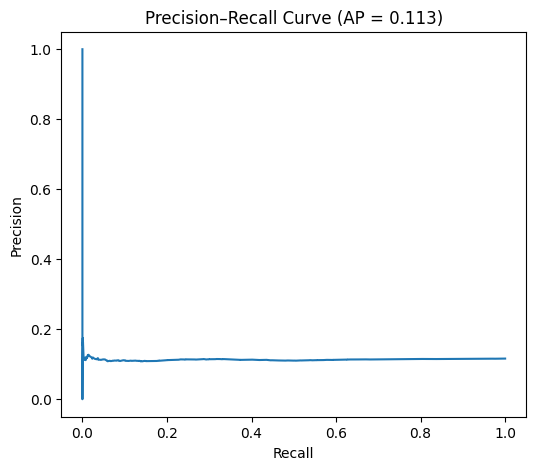

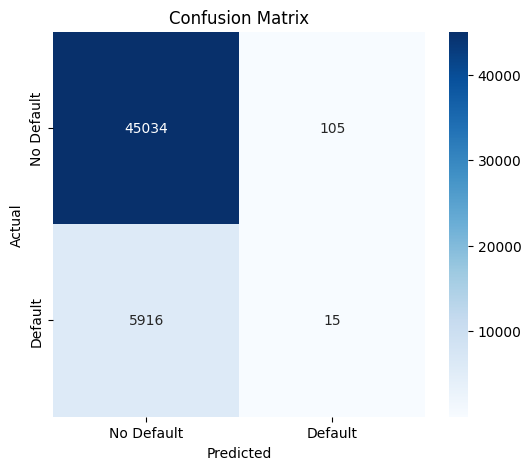

Evaluation Metrics
Accuracy:          0.8821
Balanced Accuracy: 0.5001
Precision (+):     0.1250
Recall (+):        0.0025
F1-score (+):      0.0050
ROC-AUC:           0.4881
PR-AUC (AP):       0.1133

Classification Report:
               precision    recall  f1-score   support

  No Default       0.88      1.00      0.94     45139
     Default       0.12      0.00      0.00      5931

    accuracy                           0.88     51070
   macro avg       0.50      0.50      0.47     51070
weighted avg       0.80      0.88      0.83     51070



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, average_precision_score
from scipy.stats import randint

ap_scorer = make_scorer(average_precision_score, needs_proba=True)

rf = RandomForestClassifier(random_state=42, n_jobs=-1, bootstrap=True)

param_distributions = {
    "n_estimators":      randint(350, 701),   # 350–700
    "max_depth":         [None, 10],          # tiny choice
    "min_samples_split": randint(2, 8),       # 2–7
    "min_samples_leaf":  randint(1, 4),       # 1–3
    "max_features":      ["sqrt", 0.8],       # small set
}

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=8,                 # very small
    scoring=ap_scorer,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True
)

# train on UNDERSAMPLED data
rf_search.fit(X_train_res_scaled, y_train_res)

print("Best CV PR-AUC:", rf_search.best_score_)
print("Best params:", rf_search.best_params_)

rf_best = rf_search.best_estimator_

_ = evaluate_model(rf_best, X_valid, y_valid,
                   class_names=("No Default","Default"),
                   plot=True)


#XGBoost

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:52:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:52:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, i

Best CV PR-AUC: nan
Best params: {'colsample_bytree': np.float64(0.8123620356542087), 'gamma': 0, 'learning_rate': np.float64(0.044674783189293105), 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 421, 'reg_alpha': np.float64(0.031198904067240532), 'reg_lambda': np.float64(4.3485016730091965), 'scale_pos_weight': 1, 'subsample': np.float64(0.9732352291549871)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [12:52:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


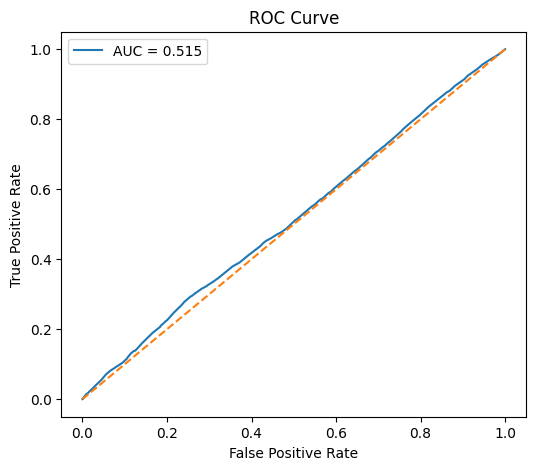

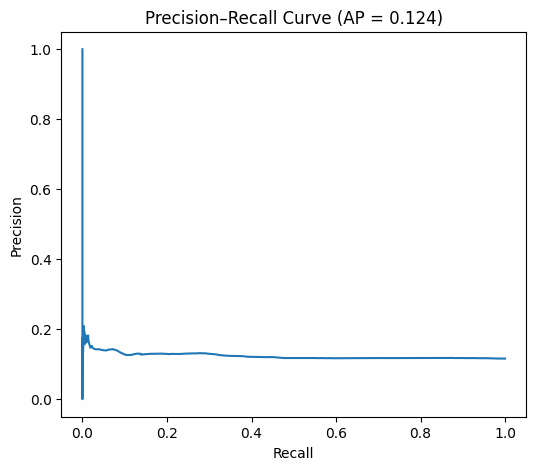

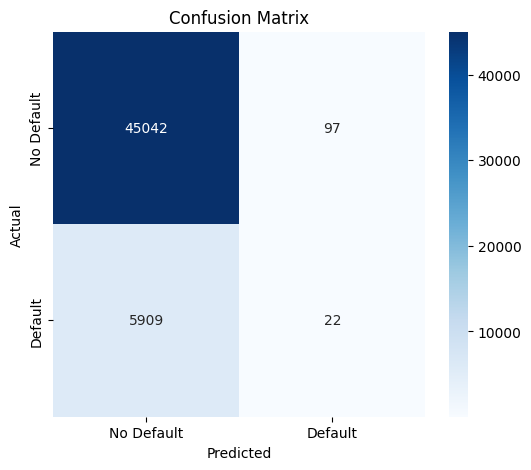

Evaluation Metrics
Accuracy:          0.8824
Balanced Accuracy: 0.5008
Precision (+):     0.1849
Recall (+):        0.0037
F1-score (+):      0.0073
ROC-AUC:           0.5146
PR-AUC (AP):       0.1236

Classification Report:
               precision    recall  f1-score   support

  No Default       0.88      1.00      0.94     45139
     Default       0.18      0.00      0.01      5931

    accuracy                           0.88     51070
   macro avg       0.53      0.50      0.47     51070
weighted avg       0.80      0.88      0.83     51070



In [ ]:
# !pip install xgboost -q  # uncomment if needed
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, average_precision_score
from scipy.stats import randint, uniform

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    tree_method="gpu_hist",
    predictor="gpu_predictor",
    random_state=42,
    n_jobs=-1
)

# --- compact random search space (fast) ---
param_distributions = {
    "learning_rate":    uniform(0.03, 0.08),   # ~0.03–0.11
    "n_estimators":     randint(300, 900),
    "max_depth":        randint(4, 7),         # 4–6
    "min_child_weight": randint(1, 7),         # 1–6
    "subsample":        uniform(0.8, 0.2),     # 0.8–1.0
    "colsample_bytree": uniform(0.7, 0.3),     # 0.7–1.0
    "gamma":            randint(0, 2),         # {0,1}
    "reg_alpha":        uniform(0.0, 0.2),
    "reg_lambda":       uniform(4.0, 6.0),
    "scale_pos_weight": [1]
}

ap_scorer = make_scorer(average_precision_score, needs_proba=True)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=12,
    scoring=ap_scorer,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True
)

# --- train on UNDERSAMPLED data ---
xgb_search.fit(X_train_res_scaled, y_train_res)

print("Best CV PR-AUC:", xgb_search.best_score_)
print("Best params:", xgb_search.best_params_)

xgb_best = xgb_search.best_estimator_

# --- evaluate on ORIGINAL validation set ---
_ = evaluate_model(
    xgb_best,
    X_valid, y_valid,
    class_names=("No Default","Default"),
    plot=True
)


#Stacking

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [11:46:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


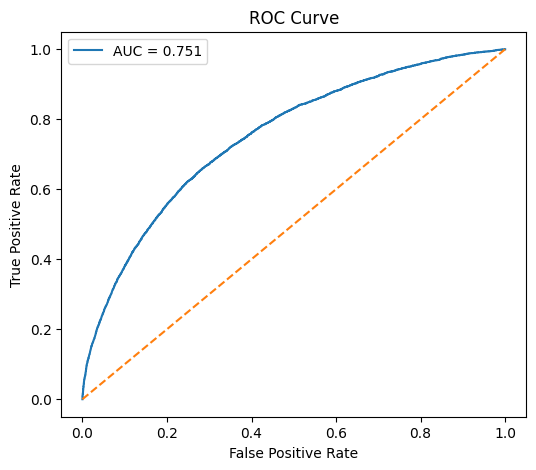

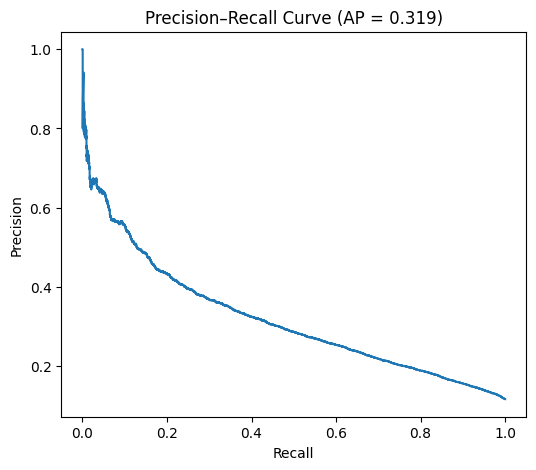

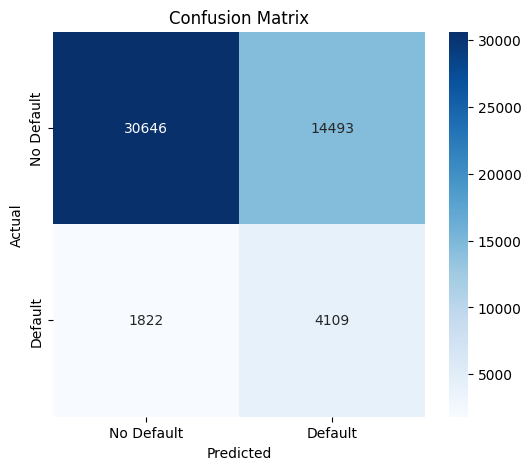

Evaluation Metrics
Accuracy:          0.6805
Balanced Accuracy: 0.6859
Precision (+):     0.2209
Recall (+):        0.6928
F1-score (+):      0.3350
ROC-AUC:           0.7513
PR-AUC (AP):       0.3192

Classification Report:
               precision    recall  f1-score   support

  No Default       0.94      0.68      0.79     45139
     Default       0.22      0.69      0.33      5931

    accuracy                           0.68     51070
   macro avg       0.58      0.69      0.56     51070
weighted avg       0.86      0.68      0.74     51070



In [ ]:
# --- build the stack using your best models ---
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone

# use whatever names you have; these must exist from your searches
# e.g. lr_best,xgb_bes rf_best, t  (or lr_grid.best_estimator_, estirf_search.best_mator_, xgb_search.best_estimator_)
lr_base  = clone(lr_best)          # keeps best hyperparams, resets to unfitted
rf_base  = clone(rf_best)
xgb_base = clone(xgb_best)

estimators = [
    ("lr",  lr_base),
    ("rf",  rf_base),
    ("xgb", xgb_base),
]

# simple meta-learner (can keep balanced for safety)
meta = LogisticRegression(max_iter=5000, class_weight="balanced", random_state=42)

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=meta,
    stack_method="predict_proba",   # use probabilities from base models
    passthrough=False,              # meta sees only base probs (clean blend)
    cv=3,
    n_jobs=-1
)

# --- train on your UNDERSAMPLED training set ---
stack.fit(X_train_res, y_train_res)

# --- evaluate on the untouched validation set ---
_ = evaluate_model(
    stack,
    X_valid, y_valid,
    class_names=("No Default","Default"),
    plot=True
)


# XGBoost with original data

In [ ]:
from sklearn.model_selection import train_test_split

X_full = df.drop(columns=["Default"]).copy()
y_full = df["Default"].copy()

# split جديد (من غير أي undersampling)
X_train_full, X_valid_full, y_train_full, y_valid_full = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

# احسب scale_pos_weight = (عدد السالب)/(عدد الموجب) من TRAIN فقط
pos = y_train_full.sum()
neg = len(y_train_full) - pos
spw = neg / pos
print(f"scale_pos_weight (neg/pos): {spw:.3f}")


scale_pos_weight (neg/pos): 7.611


In [ ]:
# !pip install xgboost -q
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, average_precision_score
from scipy.stats import randint, uniform

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    tree_method="gpu_hist",
    predictor="gpu_predictor",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=spw
)

param_distributions = {
    "learning_rate":    uniform(0.03, 0.08),  # ~0.03–0.11
    "n_estimators":     randint(300, 900),
    "max_depth":        randint(4, 7),        # 4–6
    "min_child_weight": randint(1, 7),        # 1–6
    "subsample":        uniform(0.8, 0.2),    # 0.8–1.0
    "colsample_bytree": uniform(0.7, 0.3),    # 0.7–1.0
    "gamma":            randint(0, 2),        # 0 أو 1
    "reg_alpha":        uniform(0.0, 0.2),
    "reg_lambda":       uniform(4.0, 6.0),
}

ap_scorer = make_scorer(average_precision_score, needs_proba=True)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=12,
    scoring=ap_scorer,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True
)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:57:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:57:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best CV PR-AUC: nan
Best params: {'colsample_bytree': np.float64(0.8123620356542087), 'gamma': 0, 'learning_rate': np.float64(0.044674783189293105), 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 421, 'reg_alpha': np.float64(0.031198904067240532), 'reg_lambda': np.float64(4.3485016730091965), 'subsample': np.float64(0.9732352291549871)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [11:57:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


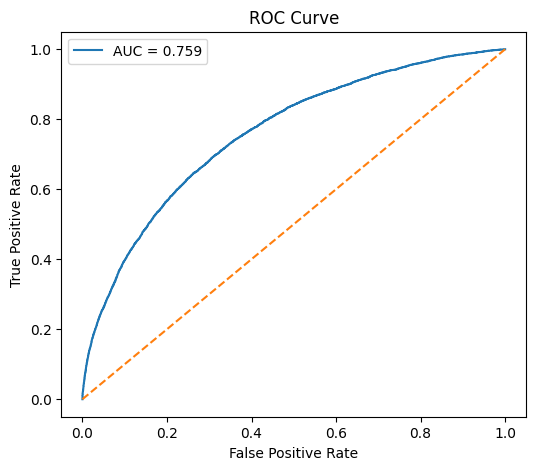

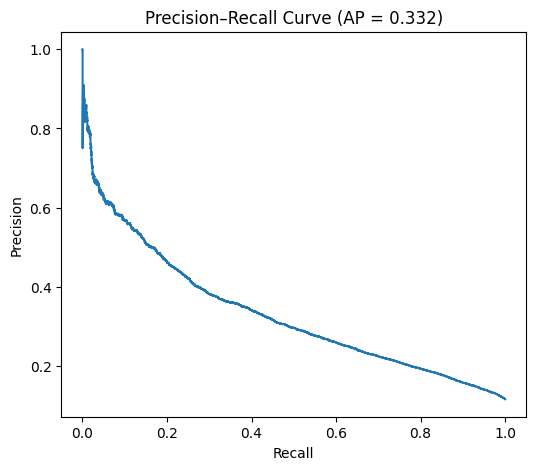

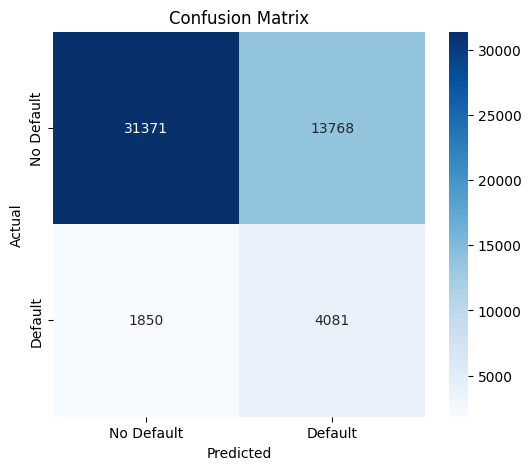

Evaluation Metrics
Accuracy:          0.6942
Balanced Accuracy: 0.6915
Precision (+):     0.2286
Recall (+):        0.6881
F1-score (+):      0.3432
ROC-AUC:           0.7589
PR-AUC (AP):       0.3324

Classification Report:
               precision    recall  f1-score   support

  No Default       0.94      0.69      0.80     45139
     Default       0.23      0.69      0.34      5931

    accuracy                           0.69     51070
   macro avg       0.59      0.69      0.57     51070
weighted avg       0.86      0.69      0.75     51070

CPU times: user 2.16 s, sys: 127 ms, total: 2.29 s
Wall time: 1min 12s


In [ ]:
%%time
xgb_search.fit(X_train_full, y_train_full)

print("Best CV PR-AUC:", xgb_search.best_score_)
print("Best params:", xgb_search.best_params_)

xgb_best = xgb_search.best_estimator_

_ = evaluate_model(
    xgb_best,
    X_valid_full, y_valid_full,
    class_names=("No Default","Default"),
    plot=True
)


#class weight

In [ ]:
from sklearn.model_selection import train_test_split

X_full = df.drop(columns=["Default"]).copy()
y_full = df["Default"].copy()

X_train_full, X_valid_full, y_train_full, y_valid_full = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

# ratio = (عدد السالب)/(عدد الموجب) من TRAIN فقط
pos = y_train_full.sum()
neg = len(y_train_full) - pos
spw = neg / pos
print(f"scale_pos_weight = {spw:.3f}")


scale_pos_weight = 7.611


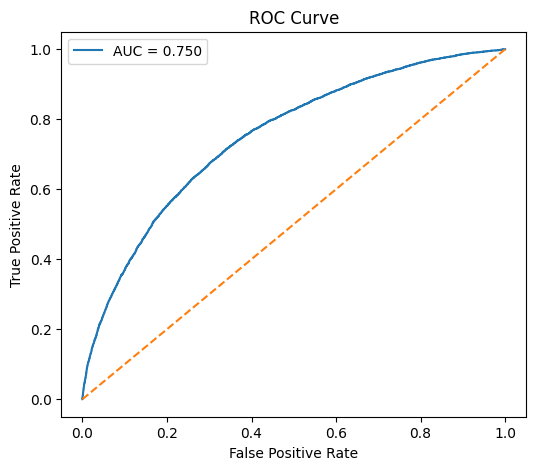

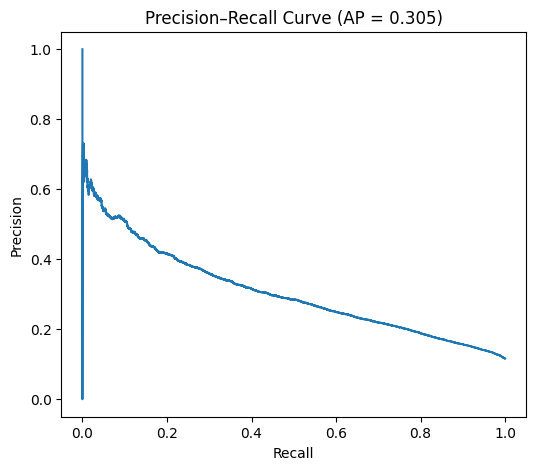

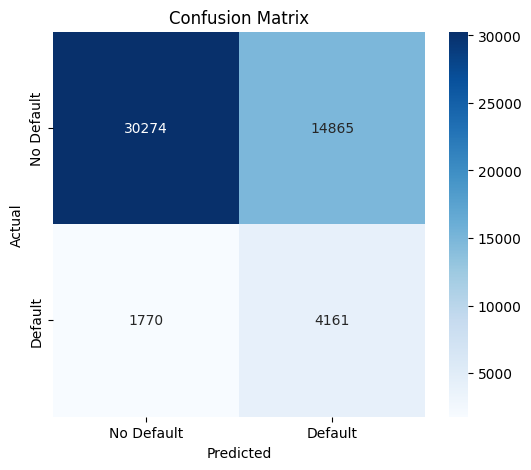

Evaluation Metrics
Accuracy:          0.6743
Balanced Accuracy: 0.6861
Precision (+):     0.2187
Recall (+):        0.7016
F1-score (+):      0.3335
ROC-AUC:           0.7502
PR-AUC (AP):       0.3054

Classification Report:
               precision    recall  f1-score   support

  No Default       0.94      0.67      0.78     45139
     Default       0.22      0.70      0.33      5931

    accuracy                           0.67     51070
   macro avg       0.58      0.69      0.56     51070
weighted avg       0.86      0.67      0.73     51070



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
Xtr_lr = scaler.fit_transform(X_train_full)
Xva_lr = scaler.transform(X_valid_full)

lr_cls = LogisticRegression(
    max_iter=5000,
    solver="lbfgs",
    class_weight="balanced",
    random_state=42
)
lr_cls.fit(Xtr_lr, y_train_full)

_ = evaluate_model(lr_cls, Xva_lr, y_valid_full,
                   class_names=("No Default","Default"), plot=True)


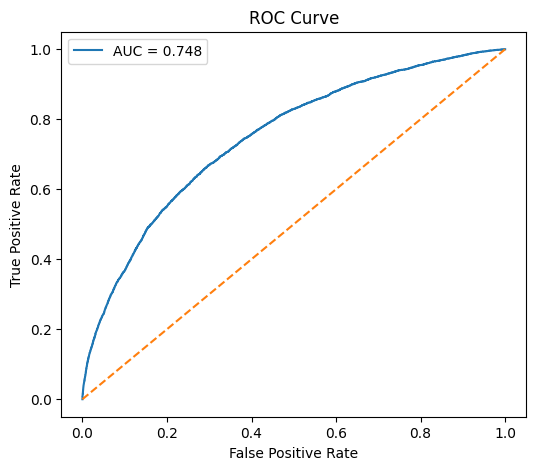

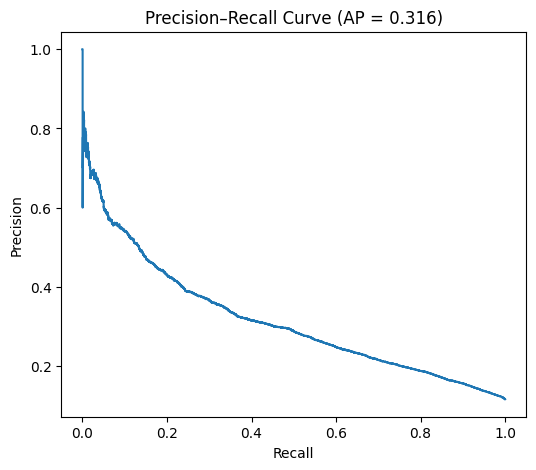

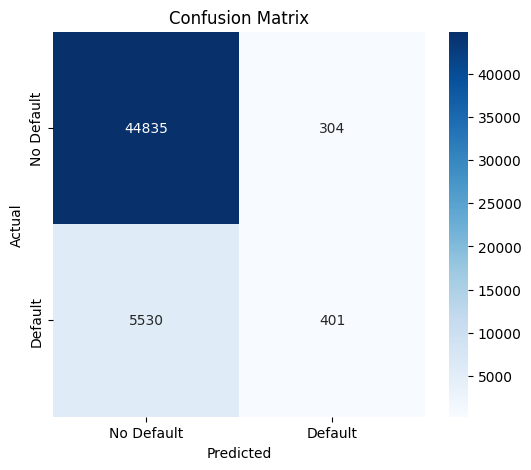

Evaluation Metrics
Accuracy:          0.8858
Balanced Accuracy: 0.5304
Precision (+):     0.5688
Recall (+):        0.0676
F1-score (+):      0.1209
ROC-AUC:           0.7484
PR-AUC (AP):       0.3158

Classification Report:
               precision    recall  f1-score   support

  No Default       0.89      0.99      0.94     45139
     Default       0.57      0.07      0.12      5931

    accuracy                           0.89     51070
   macro avg       0.73      0.53      0.53     51070
weighted avg       0.85      0.89      0.84     51070



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_cls = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    min_samples_leaf=2,
    max_features="sqrt",
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=42
)
rf_cls.fit(X_train_full, y_train_full)

_ = evaluate_model(rf_cls, X_valid_full, y_valid_full,
                   class_names=("No Default","Default"), plot=True)


# XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, average_precision_score
from scipy.stats import uniform, randint

# PR-AUC (Average Precision) is our primary metric for imbalance
ap_scorer = make_scorer(average_precision_score, needs_proba=True)

xgb = XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",   # use 'gpu_hist' if you have a GPU
    eval_metric="aucpr",
    random_state=42,
    n_jobs=-1
)

# Compact distributions for a quick search
param_distributions = {
    "learning_rate":    uniform(0.03, 0.08),   # ~0.03–0.11
    "n_estimators":     randint(300, 900),
    "max_depth":        randint(4, 7),         # {4,5,6}
    "min_child_weight": randint(1, 7),         # {1..6}
    "subsample":        uniform(0.8, 0.2),     # 0.8–1.0
    "colsample_bytree": uniform(0.7, 0.3),     # 0.7–1.0
    "gamma":            randint(0, 2),         # {0,1}
    "reg_alpha":        uniform(0.0, 0.2),     # 0.0–0.2
    "reg_lambda":       uniform(4.0, 6.0),     # 4.0–10.0
    # You’re already using RandomUnderSampler → keep scale_pos_weight at 1
    "scale_pos_weight": [1]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=12,                 # small & fast; bump to 20 if you can afford it
    scoring=ap_scorer,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True  # refit on the full undersampled training set with best params
)


In [ ]:
%%time
grid.fit(X_train_res, y_train_res)

print("Best PR-AUC (CV):", grid.best_score_)
print("Best Params:")
for k, v in grid.best_params_.items():
    print(f"  {k}: {v}")
best_model = grid.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best PR-AUC (CV): nan
Best Params:
  colsample_bytree: 0.8123620356542087
  gamma: 0
  learning_rate: 0.044674783189293105
  max_depth: 4
  min_child_weight: 5
  n_estimators: 421
  reg_alpha: 0.031198904067240532
  reg_lambda: 4.3485016730091965
  scale_pos_weight: 1
  subsample: 0.9732352291549871
CPU times: user 2.36 s, sys: 139 ms, total: 2.5 s
Wall time: 59.5 s


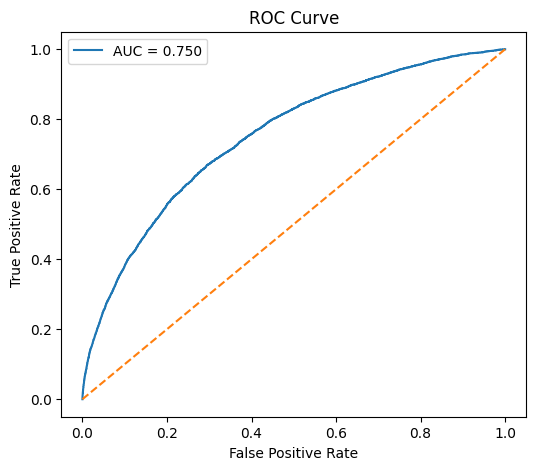

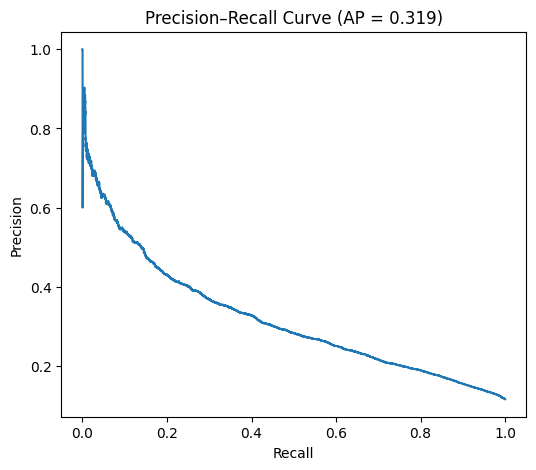

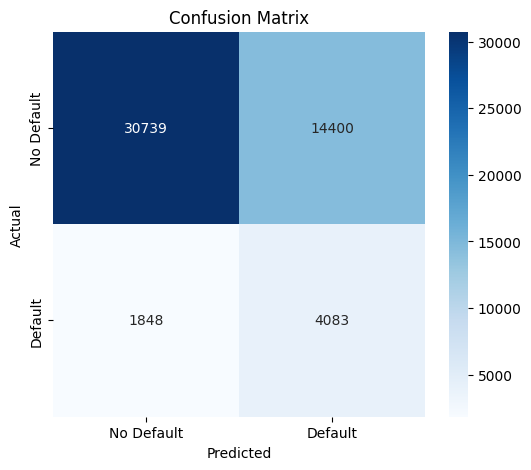

Evaluation Metrics
Accuracy:          0.6818
Balanced Accuracy: 0.6847
Precision (+):     0.2209
Recall (+):        0.6884
F1-score (+):      0.3345
ROC-AUC:           0.7501
PR-AUC (AP):       0.3191

Classification Report:
               precision    recall  f1-score   support

  No Default       0.94      0.68      0.79     45139
     Default       0.22      0.69      0.33      5931

    accuracy                           0.68     51070
   macro avg       0.58      0.68      0.56     51070
weighted avg       0.86      0.68      0.74     51070



In [ ]:
_ = evaluate_model(
    best_model,
    X_valid, y_valid,
    class_names=("No Default","Default"),
    plot=True
)



# Random forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, average_precision_score
from scipy.stats import randint, uniform

# Primary scorer for imbalance
ap_scorer = make_scorer(average_precision_score, needs_proba=True)

rf = RandomForestClassifier(
    n_jobs=-1,
    random_state=42,
    bootstrap=True,          # we'll also tune max_samples
    # class_weight=None      # since you're already undersampling
)

# Compact search space (good with ~10 features)
param_distributions = {
    "n_estimators":      randint(300, 1200),        # number of trees
    "max_depth":         [None, 6, 8, 10, 12, 14],  # None = full depth
    "min_samples_split": randint(2, 20),
    "min_samples_leaf":  randint(1, 15),
    "max_features":      ["sqrt", "log2", 0.7, 0.9, 1.0],  # fraction or rule
    "max_samples":       uniform(0.6, 0.4),         # 0.6–1.0 of rows per tree (with bootstrap)
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=15,                 # fast; bump to 25 if you can
    scoring=ap_scorer,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True
)


In [ ]:
%%time
rf_search.fit(X_train_res, y_train_res)

print("Best CV PR-AUC:", rf_search.best_score_)
print("Best params:")
for k, v in rf_search.best_params_.items():
    print(f"  {k}: {v}")

rf_best = rf_search.best_estimator_


Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best CV PR-AUC: nan
Best params:
  max_depth: 10
  max_features: 1.0
  max_samples: 0.6733739159464655
  min_samples_leaf: 8
  min_samples_split: 8
  n_estimators: 421
CPU times: user 1min 34s, sys: 1.53 s, total: 1min 35s
Wall time: 40min 22s


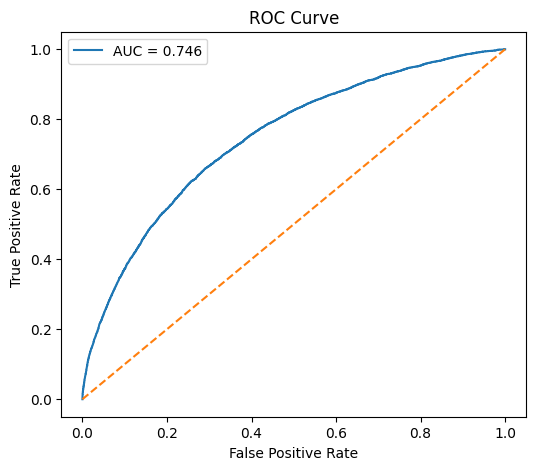

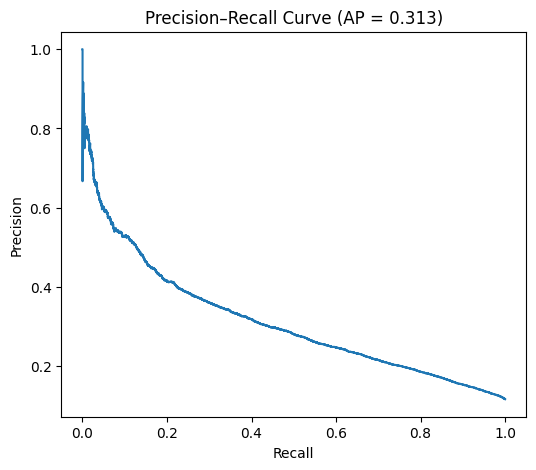

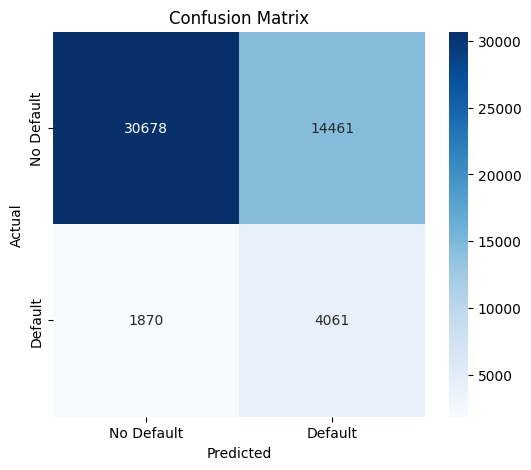

Evaluation Metrics
Accuracy:          0.6802
Balanced Accuracy: 0.6822
Precision (+):     0.2193
Recall (+):        0.6847
F1-score (+):      0.3321
ROC-AUC:           0.7459
PR-AUC (AP):       0.3127

Classification Report:
               precision    recall  f1-score   support

  No Default       0.94      0.68      0.79     45139
     Default       0.22      0.68      0.33      5931

    accuracy                           0.68     51070
   macro avg       0.58      0.68      0.56     51070
weighted avg       0.86      0.68      0.74     51070



In [ ]:
_ = evaluate_model(
    rf_best,
    X_valid, y_valid,
    class_names=("No Default","Default"),
    plot=True
)


#Logistic Regression

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, average_precision_score
from scipy.stats import loguniform, uniform

# scorer for imbalance
ap_scorer = make_scorer(average_precision_score, needs_proba=True)

pipe_lr = Pipeline([
    ("scaler", StandardScaler()),              # scale features for LR
    ("lr", LogisticRegression(
        solver="saga",                         # supports l1/l2/elasticnet + predict_proba
        max_iter=5000,
        random_state=42,
        n_jobs=None,                           # (no parallelism in LR itself)
        class_weight=None                      # using undersampling already
    ))
])

# compact distributions
param_distributions = {
    "lr__C":         loguniform(1e-3, 1e2),    # ~1e-3 .. 1e2
    "lr__penalty":   ["l2", "l1", "elasticnet"],
    "lr__l1_ratio":  uniform(0.0, 1.0),        # used only when penalty='elasticnet'
    "lr__fit_intercept": [True, False],
    "lr__tol":       [1e-4, 1e-3]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

lr_search = RandomizedSearchCV(
    estimator=pipe_lr,
    param_distributions=param_distributions,
    n_iter=20,                    # small & fast; bump if you can
    scoring=ap_scorer,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True
)


In [ ]:
%%time
lr_search.fit(X_train_res, y_train_res)

print("Best CV PR-AUC:", lr_search.best_score_)
print("Best params:")
for k, v in lr_search.best_params_.items():
    print(f"  {k}: {v}")

lr_best = lr_search.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Best CV PR-AUC: nan
Best params:
  lr__C: 0.0745934328572655
  lr__fit_intercept: True
  lr__l1_ratio: 0.1834347898661638
  lr__penalty: l2
  lr__tol: 0.0001
CPU times: user 650 ms, sys: 98.6 ms, total: 749 ms
Wall time: 13.3 s


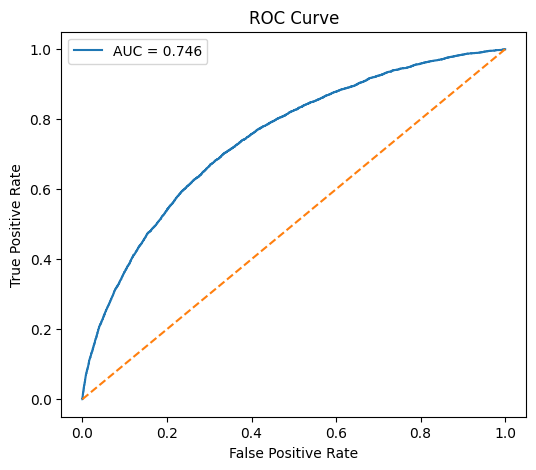

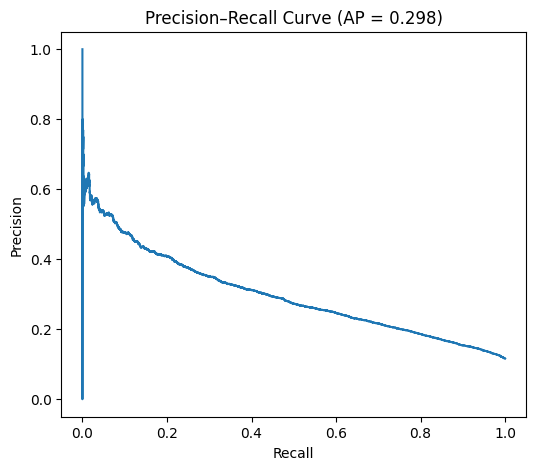

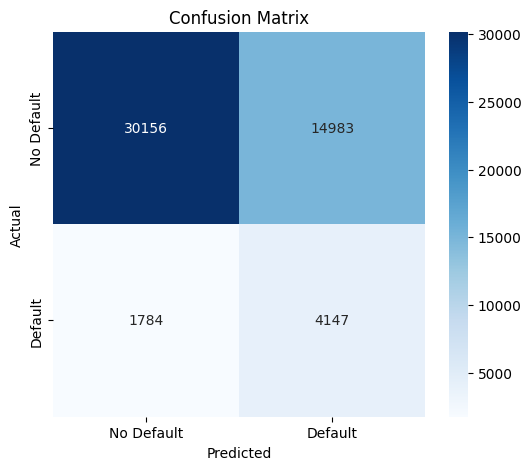

Evaluation Metrics
Accuracy:          0.6717
Balanced Accuracy: 0.6836
Precision (+):     0.2168
Recall (+):        0.6992
F1-score (+):      0.3310
ROC-AUC:           0.7456
PR-AUC (AP):       0.2981

Classification Report:
               precision    recall  f1-score   support

  No Default       0.94      0.67      0.78     45139
     Default       0.22      0.70      0.33      5931

    accuracy                           0.67     51070
   macro avg       0.58      0.68      0.56     51070
weighted avg       0.86      0.67      0.73     51070



In [ ]:
_ = evaluate_model(
    lr_best,
    X_valid, y_valid,
    class_names=("No Default","Default"),
    plot=True
)


#stacking

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier

# ----- Base models wrapped with undersampling -----

# 1) Logistic Regression (scaled)
base_lr = ImbPipeline(steps=[
    ("rus", RandomUnderSampler(random_state=42)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        solver="saga", penalty="l2", C=1.0, max_iter=5000, random_state=42
    ))
])

# 2) Random Forest
base_rf = ImbPipeline(steps=[
    ("rus", RandomUnderSampler(random_state=42)),
    ("clf", RandomForestClassifier(
        n_estimators=600, max_depth=None, min_samples_leaf=2,
        n_jobs=-1, random_state=42, bootstrap=True, max_features="sqrt"
    ))
])

# 3) XGBoost (tree booster)
base_xgb = ImbPipeline(steps=[
    ("rus", RandomUnderSampler(random_state=42)),
    ("clf", XGBClassifier(
        objective="binary:logistic",
        tree_method="hist", eval_metric="aucpr",
        learning_rate=0.07, n_estimators=700,
        max_depth=5, min_child_weight=5,
        subsample=0.9, colsample_bytree=0.8,
        gamma=0, reg_alpha=0.0, reg_lambda=5.0,
        random_state=42, n_jobs=-1, scale_pos_weight=1  # using undersampling
    ))
])

estimators = [
    ("lr",  base_lr),
    ("rf",  base_rf),
    ("xgb", base_xgb),
]

# Meta-learner (simple & robust)
meta = LogisticRegression(
    solver="lbfgs", penalty="l2", C=1.0, max_iter=2000,
    class_weight="balanced", random_state=42
)

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=meta,
    stack_method="predict_proba",   # use probabilities from base models
    passthrough=False,              # meta-learner sees only base probs (clean blend)
    cv=3,                           # OOF folds to create meta-features
    n_jobs=-1
)


In [ ]:
%%time
stack.fit(X_train, y_train)


CPU times: user 1.15 s, sys: 2.2 s, total: 3.36 s
Wall time: 3min 15s


StackingClassifier(cv=3,
                   estimators=[('lr',
                                Pipeline(steps=[('rus',
                                                 RandomUnderSampler(random_state=42)),
                                                ('scaler', StandardScaler()),
                                                ('clf',
                                                 LogisticRegression(max_iter=5000,
                                                                    random_state=42,
                                                                    solver='saga'))])),
                               ('rf',
                                Pipeline(steps=[('rus',
                                                 RandomUnderSampler(random_state=42)),
                                                ('clf',
                                                 RandomForestClassifier(min_samples_leaf=2,
                                                                        n_estimators=600,
                                                                        n_jobs=-1,
                                                                        ran...
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=5,
                                                               max_leaves=None,
                                                               min_child_weight=5,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=700,
                                                               n_jobs=-1,
                                                               num_parallel_tree=None, ...))]))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      max_iter=2000,
                                                      random_state=42),
                   n_jobs=-1, stack_method='predict_proba')

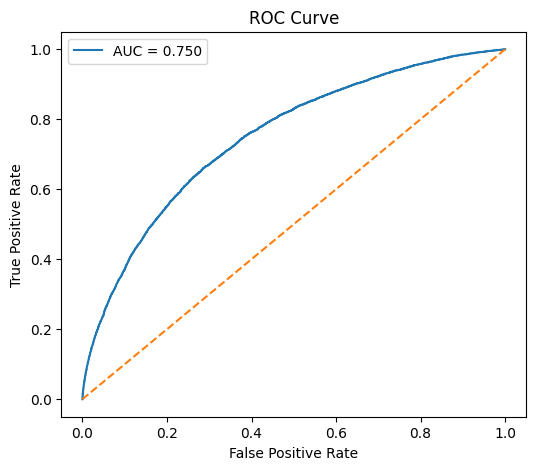

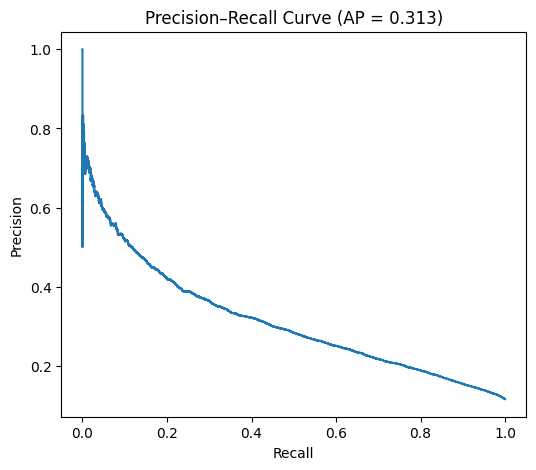

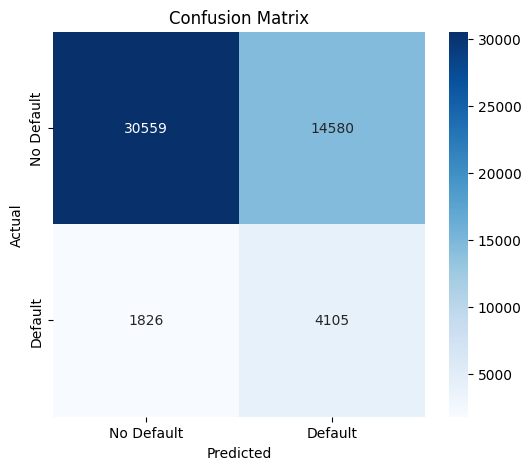

Evaluation Metrics
Accuracy:          0.6788
Balanced Accuracy: 0.6846
Precision (+):     0.2197
Recall (+):        0.6921
F1-score (+):      0.3335
ROC-AUC:           0.7497
PR-AUC (AP):       0.3127

Classification Report:
               precision    recall  f1-score   support

  No Default       0.94      0.68      0.79     45139
     Default       0.22      0.69      0.33      5931

    accuracy                           0.68     51070
   macro avg       0.58      0.68      0.56     51070
weighted avg       0.86      0.68      0.74     51070



In [ ]:
_ = evaluate_model(
    stack,
    X_valid, y_valid,
    class_names=("No Default","Default"),
    plot=True
)


In [ ]:
import numpy as np

def get_positive_scores(model, X, pos_label=1):
    if hasattr(model, "predict_proba"):
        pos_idx = np.where(model.classes_ == pos_label)[0][0]
        return model.predict_proba(X)[:, pos_idx]
    elif hasattr(model, "decision_function"):
        return model.decision_function(X)
    else:
        raise ValueError("Model has neither predict_proba nor decision_function.")

y_score = get_positive_scores(stack, X_valid, pos_label=1)


In [ ]:
print(y_score)

[0.20787669 0.16126297 0.39346479 ... 0.47035524 0.36438196 0.31686641]


In [ ]:
from sklearn.metrics import precision_recall_curve

def threshold_max_f1(y_true, y_score):
    p, r, thr = precision_recall_curve(y_true, y_score, pos_label=1)
    f1 = 2 * (p * r) / (p + r + 1e-9)
    i = int(np.nanargmax(f1))
    best_thr = thr[i-1] if i == len(thr) else thr[i]
    return best_thr, p[i], r[i], f1[i]

def threshold_for_precision(y_true, y_score, target_p=0.35):
    p, r, thr = precision_recall_curve(y_true, y_score, pos_label=1)
    ok = np.where(p[:-1] >= target_p)[0]
    if len(ok) == 0:
        return None, None, None, None
    i = ok[np.argmax(r[ok])]
    return thr[i], p[i], r[i], 2*(p[i]*r[i])/(p[i]+r[i]+1e-9)

def threshold_for_recall(y_true, y_score, target_r=0.75):
    p, r, thr = precision_recall_curve(y_true, y_score, pos_label=1)
    ok = np.where(r[:-1] >= target_r)[0]
    if len(ok) == 0:
        return None, None, None, None
    i = ok[np.argmax(p[ok])]
    return thr[i], p[i], r[i], 2*(p[i]*r[i])/(p[i]+r[i]+1e-9)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix)

def evaluate_at_threshold(y_true, y_score, thr, class_names=("No Default","Default"), plot=True):
    y_pred = (y_score >= thr).astype(int)
    acc  = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    rec  = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1   = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])

    if plot:
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f"Confusion Matrix @ thr={thr:.3f}")
        plt.xlabel("Predicted"); plt.ylabel("Actual")
        plt.show()

    print(f"Threshold: {thr:.4f}")
    print(f"Accuracy: {acc:.4f} | Balanced Acc: {bacc:.4f}")
    print(f"Precision(+): {prec:.4f} | Recall(+): {rec:.4f} | F1(+): {f1:.4f}")
    return {"threshold": thr, "accuracy": acc, "balanced_acc": bacc,
            "precision": prec, "recall": rec, "f1": f1, "cm": cm}


Best-F1 threshold ≈ 0.6417 | P=0.290, R=0.488, F1=0.364


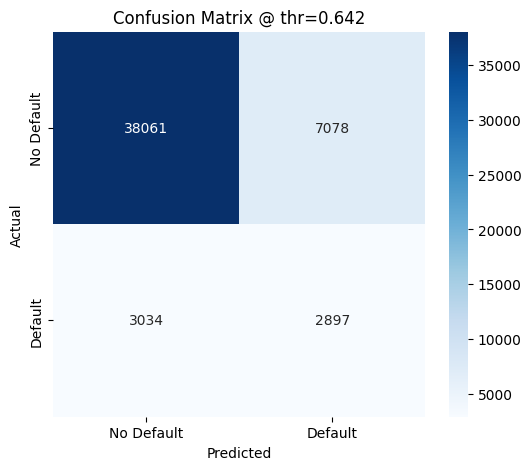

Threshold: 0.6417
Accuracy: 0.8020 | Balanced Acc: 0.6658
Precision(+): 0.2904 | Recall(+): 0.4885 | F1(+): 0.3643


In [ ]:
thr_f1, p_f1, r_f1, f1_best = threshold_max_f1(y_valid, y_score)
print(f"Best-F1 threshold ≈ {thr_f1:.4f} | P={p_f1:.3f}, R={r_f1:.3f}, F1={f1_best:.3f}")
res_f1 = evaluate_at_threshold(y_valid, y_score, thr_f1)


thr=0.7248 | P=0.350, R=0.322, F1=0.336


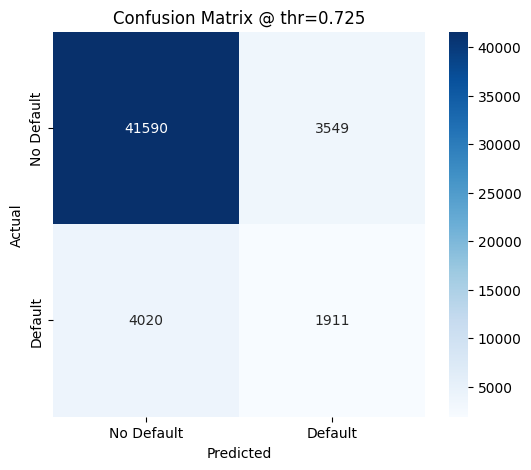

Threshold: 0.7248
Accuracy: 0.8518 | Balanced Acc: 0.6218
Precision(+): 0.3500 | Recall(+): 0.3222 | F1(+): 0.3355


In [ ]:
thr_p, p, r, f1p = threshold_for_precision(y_valid, y_score, target_p=0.35)
if thr_p is None:
    print("")
else:
    print(f"thr={thr_p:.4f} | P={p:.3f}, R={r:.3f}, F1={f1p:.3f}")
    res_p = evaluate_at_threshold(y_valid, y_score, thr_p)


thr=0.4086 | P=0.189, R=0.800, F1=0.306


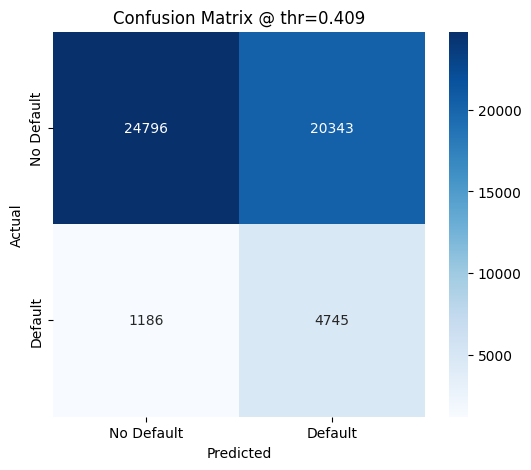

Threshold: 0.4086
Accuracy: 0.5784 | Balanced Acc: 0.6747
Precision(+): 0.1891 | Recall(+): 0.8000 | F1(+): 0.3059


In [ ]:
thr_r, p, r, f1r = threshold_for_recall(y_valid, y_score, target_r=0.80)
if thr_r is None:
    print("")
else:
    print(f"thr={thr_r:.4f} | P={p:.3f}, R={r:.3f}, F1={f1r:.3f}")
    res_r = evaluate_at_threshold(y_valid, y_score, thr_r)
